# Bladder Cancer in the United States: National Trends and State-Level

Patterns from Global Burden of Disease (GBD), 1980-2021

Burden of Bladder Cancer in the United States

Alireza Sadeghi [](https://orcid.org/0000-0002-7950-3270) (Student Research Committee, Shiraz University of Medical Sciences, Shiraz, Iran)  
Fatemeh Nouri [](https://orcid.org/0000-0002-4878-7848) (Student Research Committee, Shiraz University of Medical Sciences, Shiraz, Iran)  
Niloofar Dehdari Ebrahimi [](https://orcid.org/0000-0002-9866-8361) (Student Research Committee, Shiraz University of Medical Sciences, Shiraz, Iran)  
Ehsan Taherifard [](https://orcid.org/0000-0002-8438-4990) (Student Research Committee, Shiraz University of Medical Sciences, Shiraz, Iran)  
Wassim Kassouf [](https://orcid.org/0000-0002-8350-0531) (Division of Urology, McGill University Health Center, Montreal, QC)

In [ ]:
.body-justified p {
  text-align: justify
}

In [ ]:
# Setting up the quarto notebook

options(
  tidyverse.quiet = TRUE,
  dplyr.summarise.inform = TRUE
)

library(tidyverse)
library(scales)


Attaching package: 'scales'

The following object is masked from 'package:purrr':

    discard

The following object is masked from 'package:readr':

    col_factor

No renderer backend detected. gganimate will default to writing frames to separate files
Consider installing:
- the `gifski` package for gif output
- the `av` package for video output
and restarting the R session


Attaching package: 'flextable'

The following object is masked from 'package:purrr':

    compose

In [ ]:
# Creating the geofacet plot

geofac_data <- 
  bladder_data %>% 
  filter(location_id %in% c(stateids, 102)) %>% 
  group_by(measure_name, cause_name, metric_name) %>% 
  nest() %>% 
  ungroup()


pmap(geofac_data, geofacet_state_plot, .progress = T)

In [ ]:
# Creating the plot for comparing US performance compared to competing countries


## Line plot


us_performance_data <- 
  bladder_data %>% 
  filter(
    location_id %in% c(4743, 64, 102, 44635),
    sex_id == 1 & cause_id %in% c(468, 438) |
      sex_id == 3 & cause_id %in% c(474, 471)
  ) %>% 
  mutate(
    sex_id = NULL,
    sex_name = NULL,
    stateabb = NULL,
    location_level = NULL,
    country_group = if_else(
      location_id == 102, 
      "United States of America",
      "European Union/High-income/High SDI"
    )
  ) %>% 
  group_by(cause_name, metric_name) %>% 
  nest %>% 
  ungroup() %>% 
  mutate(
    data = 
      map(data, \(x) {
        
        if (27 %in% x$age_id) {
          
          data <- 
            x %>% 
            filter(age_id == 27)
          
          attr(data, "ageattr") <- "Age-standardized"
          
        } else {
          
          data <- 
            x %>% 
            filter(age_id == 22)
          
          attr(data, "ageattr") <- "All Ages"
          
        }
        
        return(data)
      }, .progress = T)
  )



pmap(us_performance_data, us_performance_plt, .progress = T)

In [ ]:
## Bump plot


states <- 
  bladder_data %>% 
  filter(!is.na(stateabb)) %>% 
  distinct(location_id, location_name, stateabb)

bumpyears <- 
  c(1990, 2000, 2010, 2021)

bump_data <- 
  bladder_data %>% 
  group_by(cause_name, metric_name) %>% 
  nest %>% 
  ungroup %>% 
  mutate(
    data = map(
      data, 
      \(x) {
        
        cdata <- 
          x %>% 
          select(-c(upper, lower)) %>% 
          filter(
            year %in% bumpyears,
            location_id %in% c(4743, 64, 102, 44635, stateids),
            sex_id == 1 & cause_id %in% c(468, 438) |
              sex_id == 3 & cause_id %in% c(474, 471),
            age_id %in% c(22, 27)
          )
        
        agedata <- 
          cdata %>% 
          group_by(location_id, .add = T) %>% 
          count(age_id) %>% 
          filter(age_id %in% c(22, 27)) %>%
          arrange(age_id, n) %>%
          group_by(age_id) %>% 
          summarise(sum = sum(n))
        
        if (27 %in% agedata$age_id) {
          
          cdata <- 
            cdata %>% 
            filter(age_id == 27)
          
          ageattr <- "Age-standardized"
          
        } else {
          
          cdata <- 
            cdata %>% 
            filter(age_id == 22)
          
          ageattr <- "All Ages"
          
        }
        
        cdata <- 
          cdata %>% 
          group_by(measure_name, year) %>% 
          arrange(val) %>% 
          mutate(rank = row_number()) %>% 
          arrange(measure_id, year, rank) %>% 
          mutate(order = row_number()) %>% 
          ungroup() %>% 
          mutate(
            color = if_else(
              location_id == 102 |
                (
                  year == max(.$year) & 
                    !is.na(stateabb) & 
                    !(order %>% between(6, 50))
                ), 
              "yes", "no"),
            stateabb = if_else(
              is.na(stateabb),
              location_name, stateabb
            ), 
            stateabb = if_else(
              stateabb == "United States of America",
              "USA", stateabb
            ),
            stateabb = if_else(
              stateabb == "European Union",
              "EU", stateabb
            )
          ) %>% 
          group_by(location_name, measure_name)
        # mutate(n = n()) %>% 
        # filter(n != 1) %>% 
        # mutate(n = NULL)
        
        attr(cdata, "ageattr") <- ageattr
        
        return(cdata)
        
      }, .progress = TRUE
    )
  )

pmap(bump_data, bumpplot, .progress = T)

In [ ]:
# Population pyramid plots

## Data preparation


pyramid_data <- 
  bladder_data %>% 
  filter(
    age_id %in% c(1, 6:21),
    sex_id != 3
  ) %>% 
  select(-location_level) %>% 
  arrange(age_id) %>% 
  mutate(age_name = fct_inorder(age_name)) %>% 
  group_by(
    # cause_name, 
    measure_name, 
    # metric_name,
    location_name,
  ) %>% 
  nest() %>% 
  filter(
    !(location_name %in% 
        c(
          "Middle SDI",
          "G20", 
          "Low SDI",
          "Global", 
          "High-middle SDI",
          "Low-middle SDI"
          )
      )
  )

In [ ]:
## Population pyramids for 2021

patch_plots <- list()

pmap(
  pyramid_data, 
  \(data, measure_name, location_name) {
    
    pyramid_filename <- 
      paste0(
        c(
          "fig_C",
          location_name, 
          "Bladder cancer",
          measure_name, 
          "Rate.svg"
          ), 
        collapse = "_"
        )
    
    if (
      file.exists(
        paste0(
          "output/figures/Population pyramid - 2021/",
          pyramid_filename
          )
        )
      ) {return()}
    
    plot <- 
      pyramid_plot(
        data = data,
        measure_name = measure_name
        )
    
      ggsave(
        plot = plot,
        device = "svg",
        path = "output/figures/Population pyramid - 2021/",
        filename = pyramid_filename,
        width = 25,
        height = 25,
        units = "cm",
        dpi = 600
        )
      
      if (str_detect(pyramid_filename, "United")) {
        patch_plots[[measure_name]] <<- plot
      }
    },
  .progress = TRUE
  )


if (!is_empty(patch_plots)) {
  
  library(patchwork)
  
  patch_plot <- 
    wrap_plots(patch_plots, ncol = 3, nrow = 2)
  
  ggsave(
    plot= patch_plot,
    filename = "US_combined_pyramic.svg", 
    path =  "output/figures/",
    device = "svg",
    width = 30, 
    height = 15 
    )
  
  }

In [ ]:
## Population pyramid - animated 1980-2021


years <- 
  bladder_data %>% 
  distinct(year) %>%
  pull


plan(multisession, workers = 6)

Warning in checkNumberOfLocalWorkers(workers): Careful, you are setting up 6
localhost parallel workers with only 4 CPU cores available for this R process
(per 'system'), which could result in a 150% load. The soft limit is set to
100%. Overusing the CPUs has negative impact on the current R process, but also
on all other processes of yours and others running on the same machine. See
help("parallelly.maxWorkers.localhost", package = "parallelly") for further
explanations and how to override the soft limit that triggered this warning

 ■■■■■■■■■■■■■■■■                  50% |  ETA:  2s

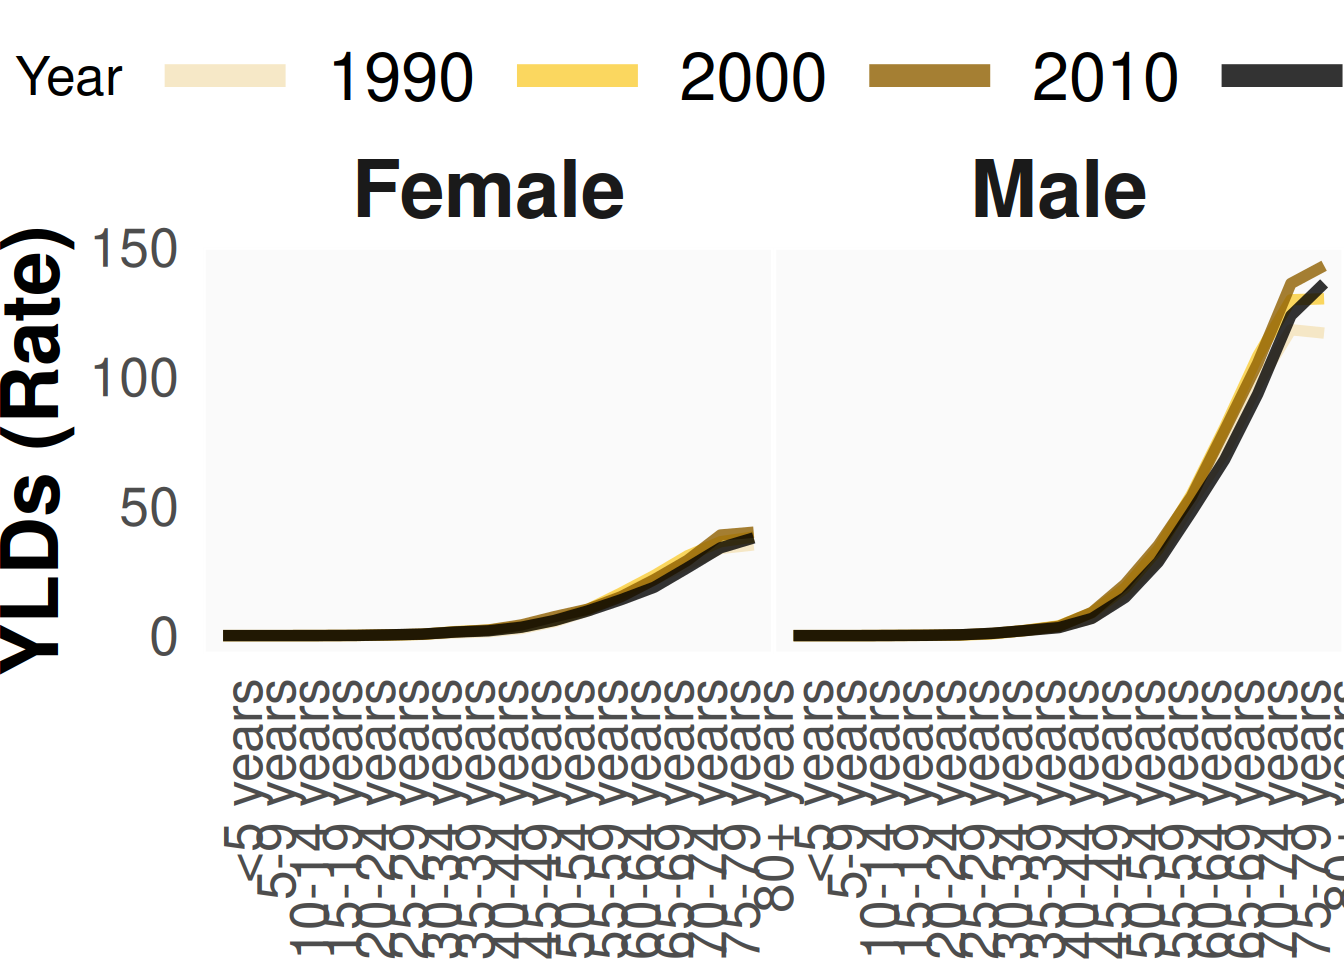

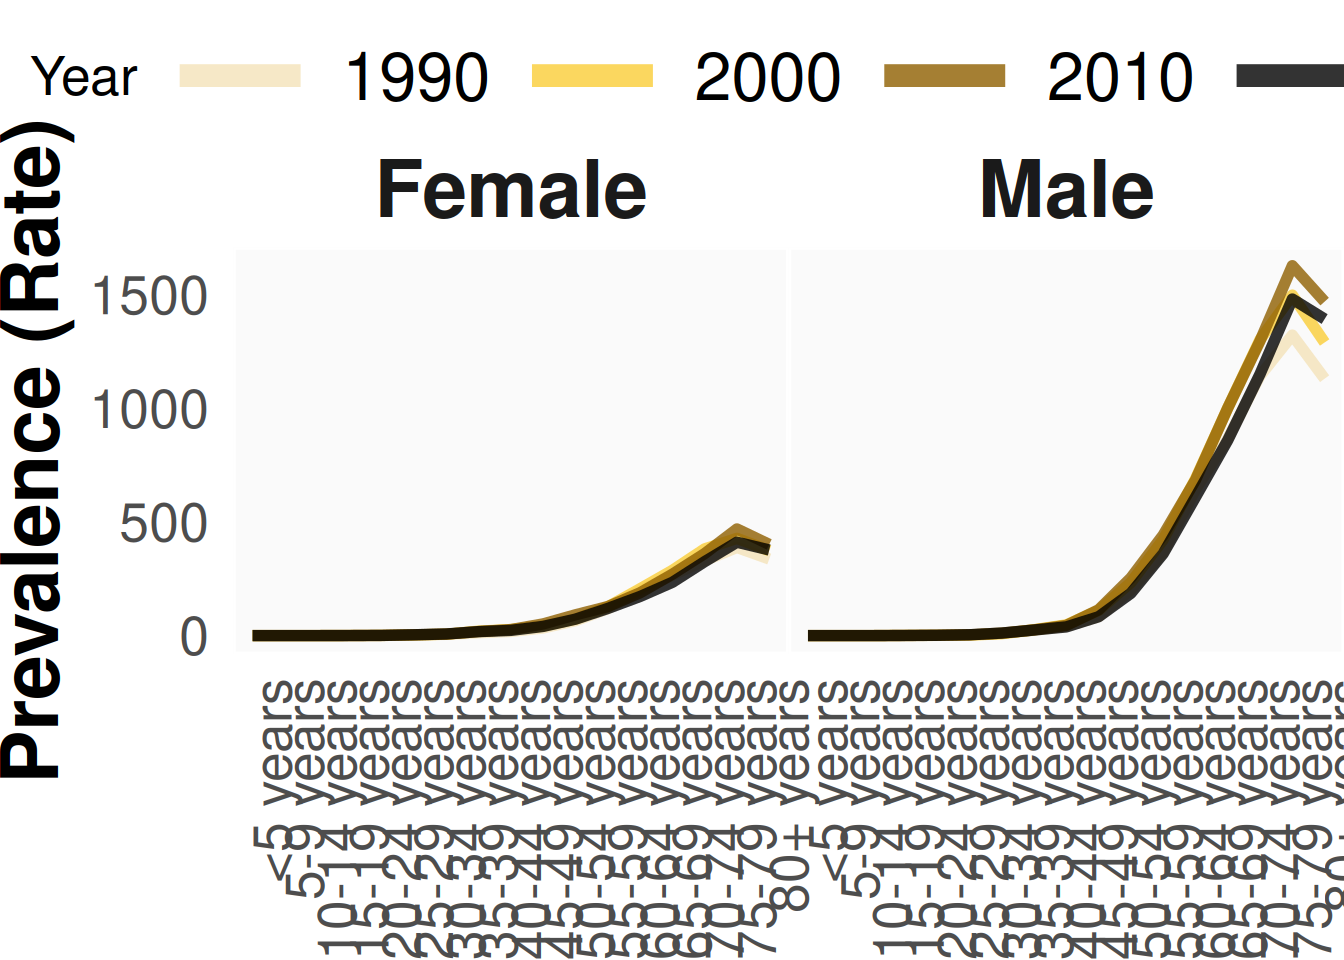

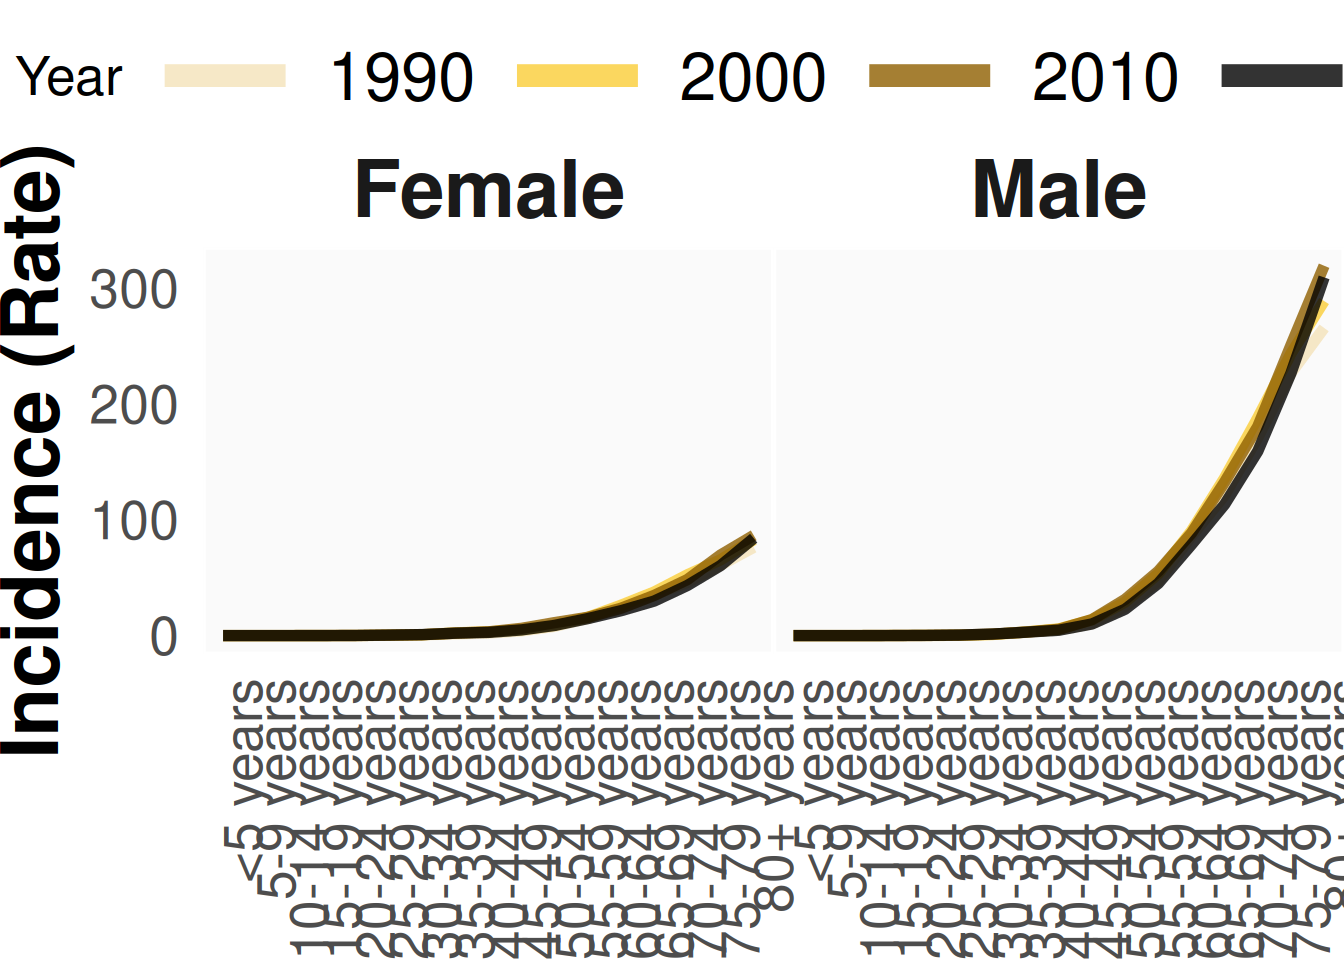

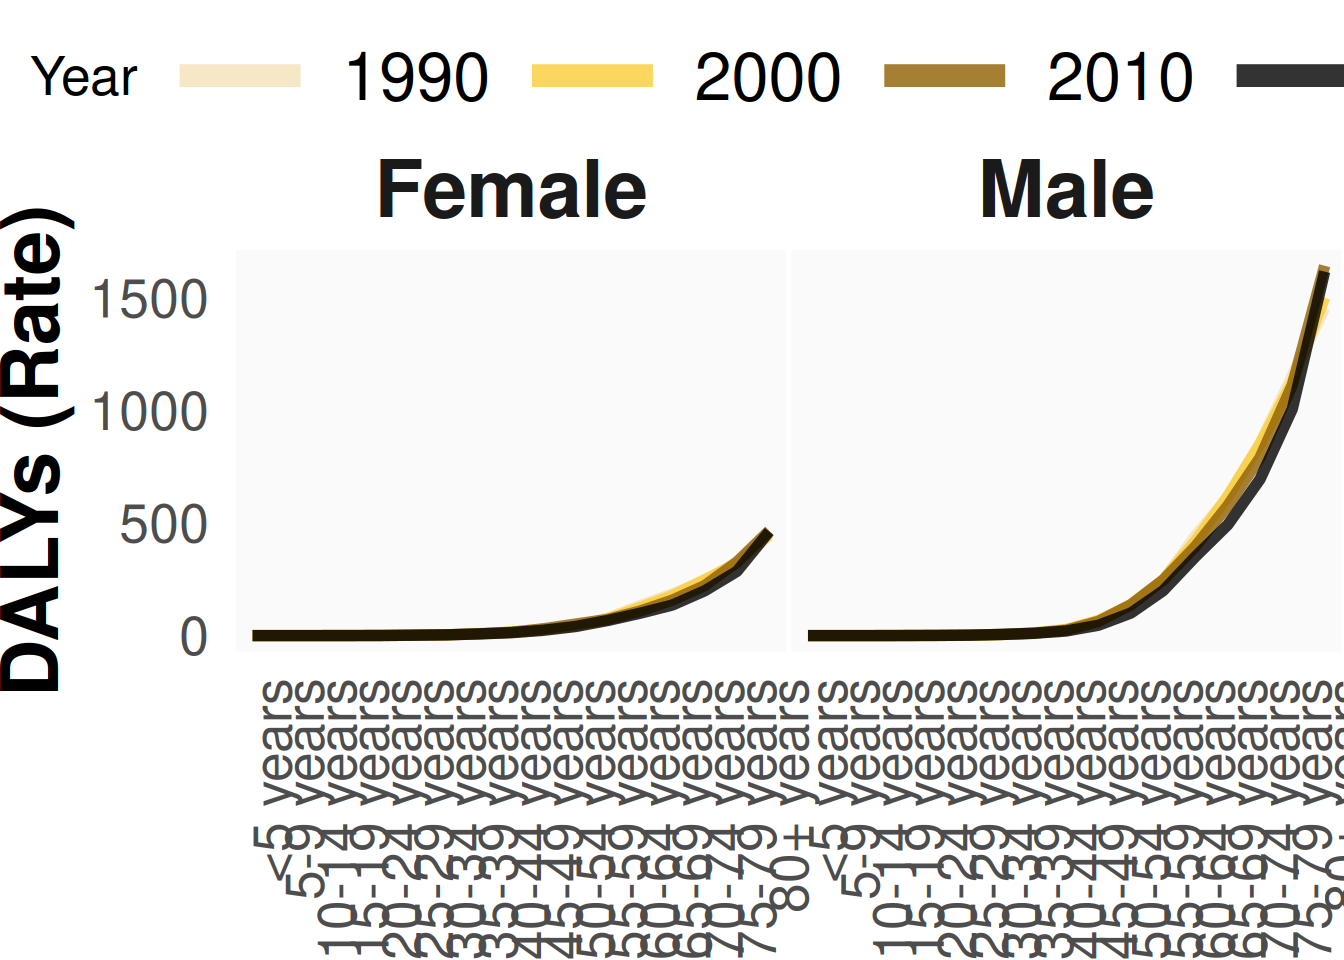

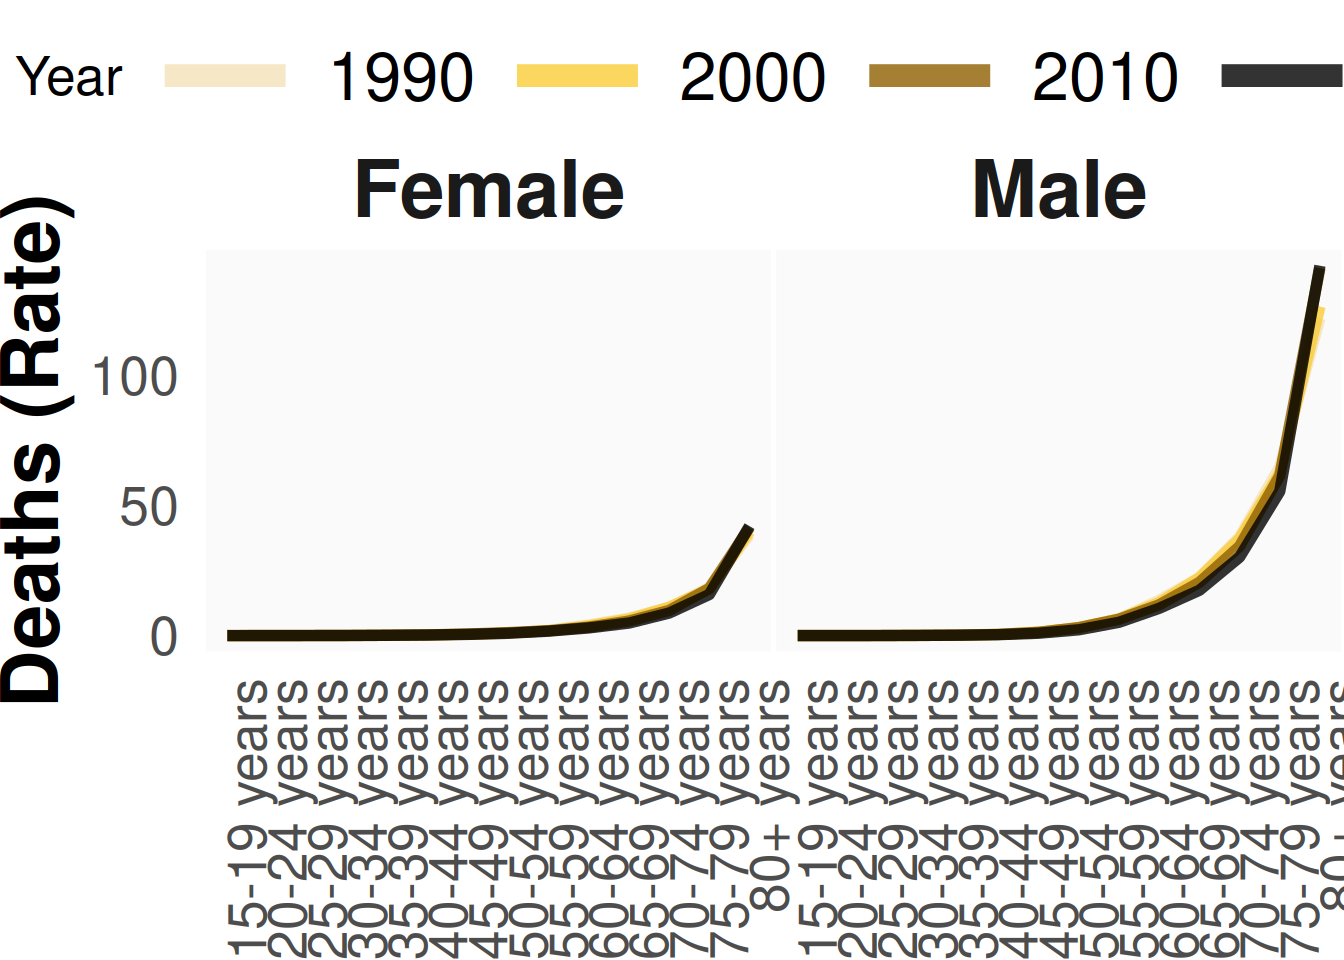

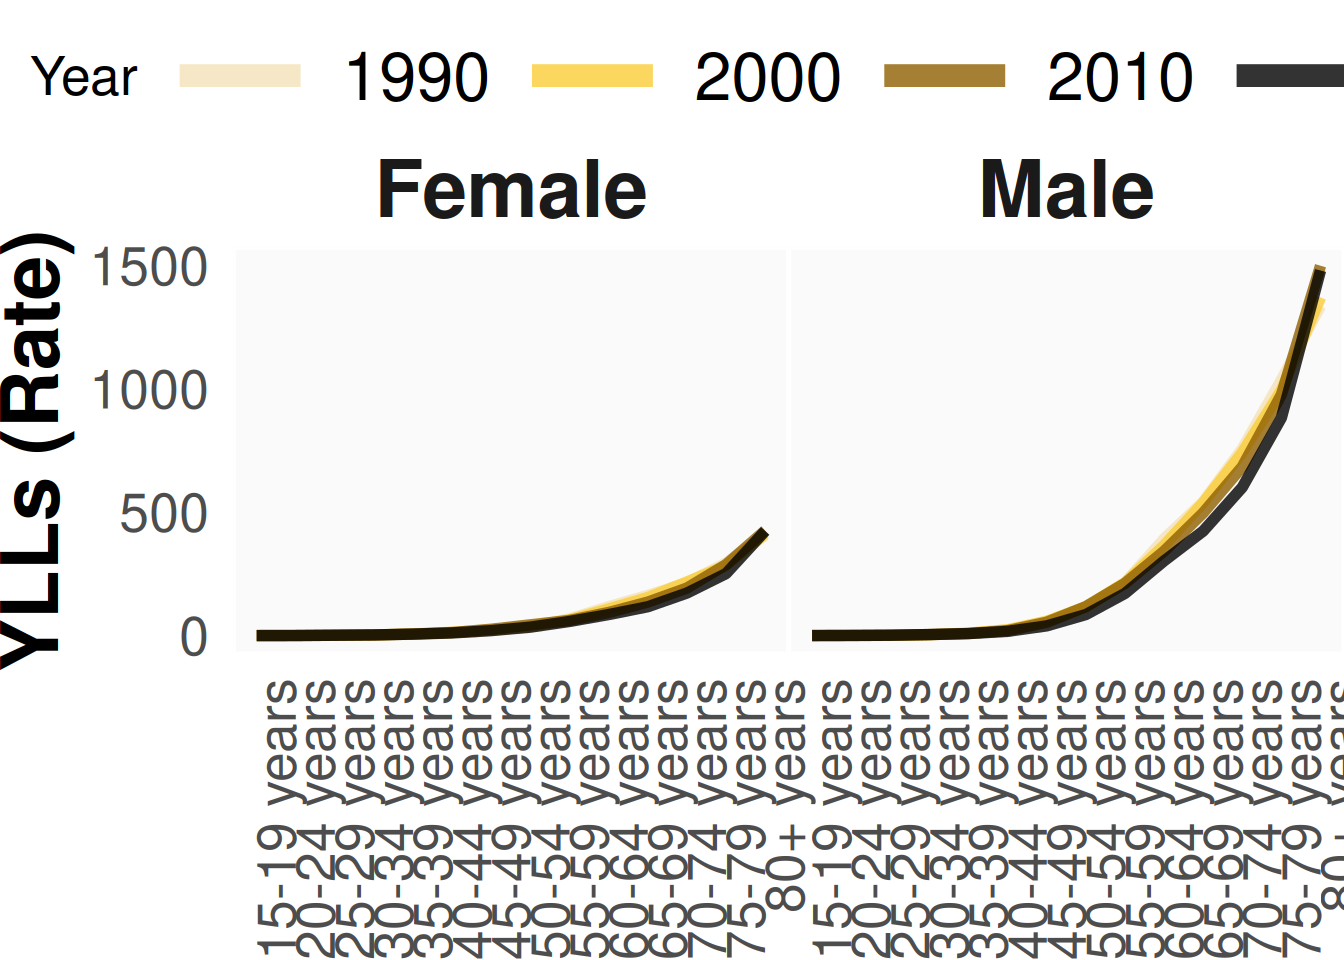

In [ ]:
# APC Plots


apc_data <- 
  bladder_data %>% 
  filter(
    year %in% c(1990, 2000, 2010, 2021),
    age_id %in% c(1, 6:21),
    location_id %in% c(stateids, 102),
    sex_id != 3,
    metric_id == 3
    ) %>% 
  arrange(age_id, year) %>% 
  mutate(
    age_name = fct_inorder(age_name)
    ) %>% 
  group_by(location_name, measure_name) %>% 
  nest

patch_plots <- list()

map(
  list(
    apc_plot1, 
    apc_plot2
    ),
  \(x) pmap(
    apc_data, 
    x
    ),
  .progress = TRUE
  )

In [ ]:
# Table

file_name <-
  paste0(
    "output/tables/Percent change since 1980 in ",
    "Bladder cancer",
    " measures.docx"
  )

change_data <-
    bladder_data %>%
    filter(
      year %in% c(2021, 1990),
      metric_id == 3,
      age_id == 27,
      sex_id != 3,
      !(location_id %in% c(1, 44639, 44634, 44586, 44636, 44637))
    ) %>%
    group_by(
      measure_name, location_name, sex_name, cause_name
    ) %>%
    select(1:6, 9, 10, 13:16, 18) %>%
    # replace true value by deviations
    mutate(upper = upper - val, lower = val - lower) %>%
    pivot_wider(
      id_cols = c(
        measure_id,
        measure_name,
        location_id,
        location_name,
        sex_id,
        sex_name,
        cause_id,
        cause_name,
        stateabb
      ),
      names_from = year,
      values_from = c(val, upper, lower),
      names_glue = "{.value}_{year}"
    ) %>%
    mutate(
      # Propagation of uncertainities
      # references in
      # https://chatgpt.com/share/68317e19-1f4c-800e-a8db-ec53c8621521
      diffval = ((val_2021 - val_1990) / val_1990),
      diffupper = diffval + ((sqrt((upper_2021^2) + (lower_1990^2))) / val_1990),
      difflower = diffval - ((sqrt((lower_2021^2) + (upper_1990^2))) / val_1990)
    ) %>%
    select(-c(val_1990:lower_2021)) %>%
    ungroup() %>%
    mutate(
      color = case_when(
        diffupper > 0 & difflower > 0 ~ "positive",
        diffupper < 0 & difflower < 0 ~ "negative",
        sign(diffupper) != sign(difflower) ~ "neutral",
      )
    ) %>%
    group_by(cause_name, measure_name) %>%
    mutate(
      upperlim = max(diffupper),
      lowerlim = min(difflower)
    ) %>%
    ungroup() 

if (!file.exists(file_name)) {
  

  table_ggplot_data <-
    change_data %>%
    mutate(
      plot = pmap(
        list(diffval, diffupper, difflower, upperlim, lowerlim, color),
        ggmaker,
        .progress = TRUE
      )
    ) %>% 
    arrange(desc(is.na(stateabb)), location_name) %>%
    mutate(
      location_name = if_else(is.na(stateabb), location_name, stateabb)
    ) %>%
    select(
      -c(diffval:lowerlim),
      -contains("_id"),
      -stateabb
    ) %>%
    rename_with(\(x) str_remove(x, "_name")) %>%
    pivot_wider(
      names_sep = "_",
      id_cols = c(location, cause),
      names_from = c(measure, sex),
      values_from = plot
    ) %>%
    group_by(cause) %>%
    nest() %>%
    mutate(
      data = if_else(
        cause %in% c("Prostate cancer", "Testicular cancer"),
        map(data, \(x) {
          x %>%
            select(-contains("Female"))
        }),
        data
      )
    )


  table_ggplot_data %>%
    mutate(
      new = map2(
        data,
        cause,
        \(x, y) fpmaker(x, y),
        .progress = TRUE
      )
    )
  
}

**Authors contact**

``` r
authors <- rmarkdown::metadata$author

author_data <- 
  authors |> 
  map(\(a) {
    tibble(
      name         = a$name,
      corresponding = a$corresponding %||% NA,
      email        = a$email %||% NA,
      orcid        = a$orcid %||% NA,
      degrees      = a$degrees %||% NA,
      roles        = list(a$roles),
      affiliations = list(map_chr(a$affiliations, "ref"))
    )
  }) |> 
  list_rbind() |>       
  unnest(c(roles, affiliations))


contacts_data <- 
  author_data %>% 
  distinct(name, email, orcid)

cat(
  glue_data(
  contacts_data, 
  "{name}\n\n   + Email <{email}>\n\n  +  ORCID [{orcid}](https://orcid.org/{orcid})\n\n\n", 
  .na = ""
  )
)
```

Alireza Sadeghi

-   Email <alireza.sadeghi.md@gmail.com>

-   ORCID [0000-0002-7950-3270](https://orcid.org/0000-0002-7950-3270)

Fatemeh Nouri

-   Email <nouri.fatmh@gmail.com>

-   ORCID [0000-0002-4878-7848](https://orcid.org/0000-0002-4878-7848)

Niloofar Dehdari Ebrahimi

-   Email <niloofar.dehdari6021@gmail.com>

-   ORCID [0000-0002-9866-8361](https://orcid.org/0000-0002-9866-8361)

Ehsan Taherifard

-   Email <etaherim123@gmail.com>

-   ORCID [0000-0002-8438-4990](https://orcid.org/0000-0002-8438-4990)

Wassim Kassouf

-   Email <Wassim.Kassouf.med@ssss.gouv.qc.ca>

-   ORCID [0000-0002-8350-0531](https://orcid.org/0000-0002-8350-0531)

In [ ]:
bladder_data <-
  bladder_data %>%
  mutate(
    readable_name = case_when(
      measure_name == "Deaths" ~ "mortality",
      measure_name == "Prevalence" ~ "prevalence",
      measure_name == "Incidence" ~ "incidence",
      .default = measure_name
    )
  )

diff_abstract <-
  bladder_data %>%
  filter(
    sex_name == "Both",
    year %in% c(1990, 2021),
    location_name == "United States of America",
    age_name == "Age-standardized"
    ) %>%
  group_by(measure_name) %>%
  select(measure_name, readable_name, year, val) %>%
  pivot_wider(names_from = year, values_from = val) %>%
  rowwise() %>%
  mutate(
    diff = `2021` - `1990`,
    than = ifelse(diff > 0, "lower", "higher"),
    diff = paste(
      diff %>%
        abs %>%
        scales::number(accuracy = 0.01),
      than
    )
    )

glue::glue_data(
  diff_abstract,
  "In 2021, The U.S. recorded age-standardized rates of {scales::number(2021, accuracy = 0.01)} for {readable_name}, which were {diff} than the 1990 records, respectively."
)


items <-
  diff_abstract %>%
  glue::glue_data("{scales::number(`2021`, accuracy = 0.01)} for {readable_name} ({diff})")

# Create the final sentence
final_sentence <-
  glue::glue(
    "In 2021, The U.S. recorded age-standardized rates of {knitr::combine_words(items, and = 'and ', sep = ', ')} compared to 1990 records."
)

In [ ]:
# State abbreviations and full names for captions

state_abbs <- 
  states %>%
  arrange(location_name) %>% 
  glue_data("{location_name}: {stateabb}; ") %>% 
  paste0(collapse = "")

country_abbs <- 
  "European Union: EU; SDI: Socio-Demographic Index"

measure_abbs <- 
  "DALYs: Disability-Adjusted Life Year; YLDs: Years Lived with Disability; YLLs: Years of Life Lost"

In [ ]:
# Supplementary file links

base_url <- 
  "https://github.com/alireza5969/gbd-bladder-cancer"

figures_base_url <- 
  paste0(
  base_url,
  "output/figures/",
  list.files("output/figures")
  )

table_base_url <- 
  paste0(
  base_url,
  "output/tables/"
  )

# 1. Abstract

**Background:** The U.S. has the highest health care expenditure globally; however, population health outcomes do not consistently reflect this level of investment. Examining long-term national and state-level trends, and benchmarking them against other health systems, can provide important insights for public health planning and policy development.  
**Aim:** This study aimed to characterize temporal trends in the burden of bladder cancer, including prevalence, incidence, mortality, disability-adjusted life years (DALYs), years lived with disability (YLDs), and years of life lost (YLLs), and to evaluate state-level disparities and potential long-term effects of health policies.  
**Methodology:** Data were obtained from the Global Burden of Disease (GBD) 2021 study. Age- and sex-stratified trends were analyzed and visualized at both national and state levels across the study period. Burden estimates were additionally compared with those of other major health systems, including the European Union, countries with high socio-demographic index, and high-income settings.  
**Results:** In 2021, The U.S. recorded age-standardized rates of 8.35 for YLDs (0.33 lower), 3.41 for mortality (0.11 higher), 59.80 for YLLs (6.75 higher), 100.63 for prevalence (6.61 lower), 14.69 for incidence (0.51 lower), and 68.15 for DALYs (6.42 higher) compared to 1990 records.  
**Conclusion:** Bladder cancer continues to impose a substantial and uneven burden across the U.S.. Reducing these disparities will require targeted public health strategies and region-specific policies that address modifiable risk factors, enhance diagnostic equity, and expand access to timely detection and appropriate care.

**Keywords:** *bladder cancer; global burden of disease; United States of America; incidence; mortality; prevalence*



# 2. Introduction

Bladder cancer (BC) is the sixth most common malignancy in the U.S. ([1](#ref-RN1)). Among American men, it ranks as the fourth most frequently diagnosed cancer and the seventh leading cause of cancer-related mortality ([2](#ref-RN2)). According to recent estimates from the Surveillance, Epidemiology, and End Results (SEER) Program, approximately 84,870 new cases and 17,420 deaths are projected for 2025, representing 4.2% of all new cancer diagnoses and 2.8% of cancer-related deaths nationwide ([1](#ref-RN1)). Similar patterns are observed globally, with an increasing absolute burden despite declining age-standardized rates, underscoring BC as a persistent and growing public health challenge ([3](#ref-RN3)).

Beyond its epidemiological impact, BC imposes a substantial economic burden. Its management commonly requires lifelong surveillance and repeated therapeutic interventions, rendering it the most costly cancer to treat on a per-patient lifetime basis ([4](#ref-RN4)–[6](#ref-RN6)). In addition to direct healthcare expenditures, BC exerts profound effects on patients’ quality of life and significantly impacts the emotional, social, and practical well-being of caregivers and families ([7](#ref-RN7)).

Although cigarette smoking has historically been the predominant risk factor for BC ([8](#ref-RN8)), accumulating evidence indicates that a broader spectrum of carcinogenic exposures contributes to its incidence. These include arsenic-contaminated drinking water, occupational and cosmetic chemicals (such as those found in hair dyes), dietary factors, and widespread environmental pollutants ([9](#ref-RN9)). Notably, despite a sustained decline in cigarette smoking prevalence since 1998 ([10](#ref-RN10)) and the introduction of stricter regulations on aryl amines, BC incidence has not declined in parallel ([11](#ref-RN11)). This lack of concordance suggests that other environmental and occupational exposures may be driving contemporary disease patterns, particularly in regions with limited regulatory oversight. Elevated BC incidence in certain New England states, for example, has been partially attributed to environmental carcinogens such as arsenic contamination from private household wells ([12](#ref-RN12),[13](#ref-RN13)). The interaction of these exposures with persistent regional and socioeconomic disparities represents a critical yet incompletely characterized public health concern, warranting focused surveillance, research, and policy attention.

Substantial geographic heterogeneity in BC incidence and outcomes has been documented across the U.S. ([14](#ref-RN14)–[17](#ref-RN17)). For instance, Maine reported an age-standardized incidence rate of 26.7 during 2017–2021, nearly double that observed in Hawaii (13.4) ([18](#ref-RN18)). Such variation likely reflects differences in environmental exposures, socioeconomic conditions, access to care, and healthcare infrastructure. Incidence rates tend to be highest in northeastern states ([16](#ref-RN16)), whereas mortality is disproportionately greater in Southern states ([19](#ref-RN19)), where higher proportions of older adults, African Americans, and rural residents may experience delayed diagnosis and reduced access to high-quality treatment ([20](#ref-RN20)). <!-- Additionally, while men are more frequently diagnosed, women often experience worse --> <!-- outcomes, including higher stage at diagnosis and lower survival rates [@RN21]. -->

Despite these observations, most prior BC research has focused on national trends or single-institution cohorts, and contemporary age-standardized, state-level comparisons remain limited. Furthermore, although the Global Burden of Disease (GBD) project produces comprehensive estimates of disability-adjusted life years (DALYs), years lived with disability (YLDs), and years of life lost (YLLs) for BC, these measures have been infrequently incorporated into disease-specific epidemiological analyses. As a result, non-fatal burden and broader health-system impacts remain underexplored. National studies indicate that men experience approximately three to four times higher BC incidence than women ([21](#ref-RN22)), whereas women often present with more advanced disease and have poorer survival ([22](#ref-RN23)); however, the geographic distribution of these sex-specific disparities has not been systematically evaluated at the state level.

To address these gaps, we use data from the GBD 2021 study, which provides internally consistent estimates of key BC burden metrics across all U.S. states. This predominantly descriptive analysis offers a comprehensive assessment of BC burden across geographic regions, time, and age groups, with the aim of informing state-level public health planning and prioritization.

# 3. Methodology

## 3.1 Study Design and Data Sources

This population-based study used data from the GBD 2021 database. The GBD provides comprehensive, internally consistent, and modeled estimates for diseases and injuries across all U.S. states, enabling standardized comparisons over time, geography, age, sex, and socioeconomic strata. These features make the GBD particularly well suited for examining disparities in BC burden at national and subnational levels ([23](#ref-ferrari2024),[24](#ref-naghavi2024)). All data are publicly available through the [Global Health Data Exchange (GHDx)](https://ghdx.healthdata.org/).

We analyzed BC burden across all U.S. states from 1980 to 2021. Estimates for incidence, prevalence, mortality, YLLs, YLDs, and DALYs were extracted for males, females, both sexes combined, and all age groups. For international benchmarking, corresponding data were also retrieved for the European Union, high-income countries, and high Socio-Demographic Index (SDI) regions. Both age-specific and age-standardized estimates were obtained for each metric. Results are reported as rates per 100,000 population with accompanying 95% uncertainty intervals, as generated by the GBD framework. This study adheres to the Guidelines for Accurate and Transparent Health Estimates Reporting statement.

## 3.2 Definitions

Bladder cancer  
Defined in GBD 2021 using the International Classification of Diseases (ICD) coding system: ICD-10 codes C67–C67.9 and ICD-9 codes 188–188.9, V10.51, V16.52, and V76.3 ([23](#ref-ferrari2024),[25](#ref-feigin2021)).

Disability-adjusted life years (DALYs)  
A summary measure of population health that quantifies the gap between current health status and an ideal standard in which the entire population lives to advanced age in full health. This metric combines YLDs and YLLs due to premature mortality.

Years of life lost (YLLs)  
The fatal component of DALYs, reflecting the number of years lost due to death occurring before the reference life expectancy.

Years lived with disability (YLDs)  
The non-fatal component of DALYs, representing time lived in health states less than full health, weighted by severity.

Socio-Demographic Index (SDI)  
A composite measure developed within the GBD framework that reflects levels of development based on income per capita, average educational attainment among individuals aged 15 years or older, and fertility rates among those younger than 25 years ([26](#ref-instituteforhealthmetricsandevaluation2024)). The index ranges from 0 to 1 and is used to classify countries or regions into five categories: low, low-middle, middle, high-middle, and high. High-SDI countries were included as one of the comparator groups in this study.

Competing countries  
Country groupings considered broadly comparable to the U.S. in terms of economic development and health-system context. These included the European Union, high-income countries, and high-SDI regions.

Age-standardized rates  
Rates standardized to the GBD global age structure using the direct method, calculated as:

$$
\frac{ \sum_{i=1}^{A} a_i w_i }{ \sum_{i=1}^{A} w_i } \times 100{,}000
$$

where $a_i$ denotes the age-specific rate for age group $i$, $w_i$ represents the corresponding standard population weight, and $A$ is the total number of age groups.

## 3.3 Statistical Analysis

Age-standardized rates were calculated for each burden metric using the GBD 2021 world standard population. Temporal trends were evaluated across the full study period from 1980 to 2021 at both national and state levels. All rates are presented per 100,000 population with corresponding 95% uncertainty intervals.

Uncertainty intervals reflect the GBD Bayesian modeling framework and are defined by the 2.5th and 97.5th percentiles of 500 posterior draws. These intervals account for multiple sources of uncertainty, including data sparsity, measurement error, and model specification ([24](#ref-naghavi2024)).

All analyses were conducted using R version 4.5.1 (2025-06-13 ucrt). A total of 28 R packages were used to support data acquisition, processing, visualization, analysis, and reproducibility ([27](#ref-allaire2024b)–[55](#ref-xie2025)). To enable full reproducibility, complete analytic code, data-processing workflows, and supporting files are available in the study’s [GitHub repository](https://github.com/alireza5969/gbd-bladder-cancer).

# 4. Results

## 4.1 U.S. Compared to Competing Countries

``` r
incidence_death_us_2021 <-
  bladder_data %>%
  filter(
    location_name == "United States of America", 
    age_name == "Age-standardized",
    year == 2021,
    measure_name %in% c('Incidence', "Deaths"),
    sex_name != "Both"
    ) %>% 
  select(measure_name, sex_name, val, upper, lower) 


incidence_death_us_2021_txt <- 
  glue_data(
    incidence_death_us_2021,
    "{number(val, .1)} [{number(lower, .1)}, {number(upper)}]"
  )

incidence_death_compete_2021 <- 
  bladder_data %>%
  filter(
    is.na(stateabb), 
    age_name == "Age-standardized",
    year == 2021,
    measure_name %in% c('Incidence', "Deaths"),
    sex_name == "Both"
    ) %>% 
  select(measure_name, location_name, val, upper, lower)


incidence_death_compete_2021_txt <- 
  glue_data(
    incidence_death_compete_2021,
    "{number(val, .1)} [{number(lower, .1)}, {number(upper)}]"
  )
```

In 2021, the age-standardized incidence rates in the U.S. were 24.0 \[22.4, 25.2\] and 7.1 \[6.3, 7.4\] for men and women, respectively, corresponding to mortality rates of 5.8 \[5.2, 6.1\] and 1.7 \[1.4, 1.8\]. In the same year, European Union, high-income, and high-SDI countries reported mortality rates of 4.6 \[4.1, 4.893\], 3.5 \[3.1, 3.723\], and 3.4 \[3.0, 3.611\], respectively, for both sexes combined.

``` r
max_vals_us <- 
  bladder_data %>%
    filter(
        measure_name %in% c('Incidence', "Prevalence"),
        location_name == "United States of America",
        age_name == "Age-standardized", 
        sex_name == "Both"
    ) %>% 
    group_by(measure_name) %>% 
    slice_max(val) %>% 
    select(val, upper, lower, year)
```

    Adding missing grouping variables: `measure_name`

``` r
max_vals_us_txt <- 
  glue_data(
    max_vals_us,
    "{number(val, .1)} [{number(lower, .1)}, {number(upper)}]"
    )
```

With peak age-standardized incidence and prevalence rates of 16.5 \[15.4, 17\] and 113.9 \[108.3, 117\] observed in 2011, the U.S. has exhibited persistently higher incidence and prevalence of BC compared with competing countries throughout most of the 1980–2021 period. In contrast, age-standardized rates of DALYs, YLLs, and mortality in the U.S. have remained lower than those of comparator regions since the early 2000s. Notably, the pronounced and consistent declining trends observed in competing countries are largely absent in the U.S. Although these burden metrics have historically been lower in the U.S., competing countries have progressively converged toward U.S. levels over time (<a href="#fig-performance" class="quarto-xref">Figure 1</a>).

<figure id="fig-performance">

<figcaption>Figure 1: Age-standardized bladder cancer burden rates between 1980 and 2021 in the U.S. compared with high-income and high Socio-Demographic Index countries and the European Union.</figcaption>
</figure>

    Abbreviations: DALYs: Disability-Adjusted Life Year; YLDs: Years Lived with Disability; YLLs: Years of Life Lost

``` r
country_change_data <- 
  change_data %>% 
  filter(
    is.na(stateabb),
    ) %>% 
  mutate(
    sex_name = if_else(sex_id == 2, "women", "men"),
    across(diffval:difflower, \(x) return(abs(x) * 100))
    )

green_change_data <- 
  country_change_data %>% 
    filter(
        color == "negative",
        measure_name %in% c(
          "DALYs", 
          "YLLs",
          "Deaths"
          # "Incidence"
          )
    ) %>% 
    pivot_wider(
      values_from = diffval:difflower,
      names_from = sex_name,
      id_cols = c(measure_name, location_name)) %>%
  arrange(measure_name, location_name)

red_change_data <- 
  country_change_data %>% 
  filter(color == "positive")

green_change_txt <- 
  glue_data(
    green_change_data,
    "men: {number(diffval_men, .1)}% [{number(difflower_men, .1)}%, {number(diffupper_men, .1)}%]; women: {number(diffval_women, .1)}% [{number(difflower_women, .1)}%, {number(diffupper_women, .1)}%]", 
    .na = ""
    )

incidence_green_change_data <- 
  country_change_data %>% 
    filter(
        color %in% c("negative", "neutral"),
        measure_name == "Incidence",
        sex_name == "men"
        )

incidence_green_change_txt <- 
  glue_data(
    incidence_green_change_data,
    "{number(diffval, .1)}% [{number(difflower, .1)}%, {number(diffupper, .1)}%]", 
    .na = ""
    )

red_change_txt <- 
  glue_data(
    red_change_data,
    "{number(diffval, .1)}% [{number(difflower, .1)}%, {number(diffupper, .1)}%]"
    )
```

A complementary quantitative summary of the trends shown in <a href="#fig-performance" class="quarto-xref">Figure 1</a> is provided in <a href="#tbl-percentchange" class="quarto-xref">Table 1</a>, which presents the percentage change in age-standardized rates between 1980 and 2021 for all burden measures. Consistent with the visual trends, the table demonstrates significant reductions in DALYs (men: 34.6% \[40.3%, 29.2%\]; women: 26.6% \[36.2%, 17.6%\], men: 30.9% \[36.8%, 25.4%\]; women: 24.5% \[34.4%, 15.5%\], men: 30.2% \[36.0%, 24.2%\]; women: 19.4% \[29.4%, 10.8%\], and men: 11.8% \[20.1%, 4.6%\]; women: 12.4% \[23.1%, 2.1%\]) and YLLs (men: 36.4% \[41.7%, 31.4%\]; women: 28.4% \[37.4%, 19.9%\], men: 32.6% \[38.2%, 27.5%\]; women: 26.2% \[35.5%, 17.4%\], men: 31.9% \[37.4%, 26.3%\]; women: 21.3% \[31.3%, 12.9%\], and men: 13.3% \[20.3%, 7.3%\]; women: 13.9% \[24.2%, 4.6%\]) across high-income and high-SDI countries, the European Union, and the U.S., respectively. By contrast, while high-income and high-SDI countries and the European Union achieved significant declines in mortality (men: 30.7% \[37.8%, 23.8%\]; women: 26.2% \[38.8%, 14.0%\], men: 27.3% \[34.9%, 20.4%\]; women: 23.3% \[36.5%, 11.0%\], and men: 26.6% \[33.9%, 19.5%\]; women: 21.3% \[33.8%, 10.1%\], respectively) and male incidence (15.3% \[22.0%, 9.4%\], 11.8% \[18.5%, 5.9%\], 10.0% \[17.6%, 3.2%\]), changes in the U.S. were comparatively modest and statistically non-significant (0.4% \[7.9%, 5.7%\]).

<figure id="tbl-percentchange">

<figcaption>Table 1: Percentage change in age-standardized rates between 1980 and 2021 in the U.S. compared with competing countries. Bars and error lines indicate mean percentage change and 95% confidence intervals. Green, yellow, and red denote significant decrease, non-significant change, and significant increase, respectively.</figcaption>
</figure>

    Abbreviations: DALYs: Disability-Adjusted Life Year; YLDs: Years Lived with Disability; YLLs: Years of Life Lost; European Union: EU; SDI: Socio-Demographic Index; Alabama: AL; Alaska: AK; Arizona: AZ; Arkansas: AR; California: CA; Colorado: CO; Connecticut: CT; Delaware: DE; District of Columbia: DC; Florida: FL; Georgia: GA; Hawaii: HI; Idaho: ID; Illinois: IL; Indiana: IN; Iowa: IA; Kansas: KS; Kentucky: KY; Louisiana: LA; Maine: ME; Maryland: MD; Massachusetts: MA; Michigan: MI; Minnesota: MN; Mississippi: MS; Missouri: MO; Montana: MT; Nebraska: NE; Nevada: NV; New Hampshire: NH; New Jersey: NJ; New Mexico: NM; New York: NY; North Carolina: NC; North Dakota: ND; Ohio: OH; Oklahoma: OK; Oregon: OR; Pennsylvania: PA; Rhode Island: RI; South Carolina: SC; South Dakota: SD; Tennessee: TN; Texas: TX; Utah: UT; Vermont: VT; Virginia: VA; Washington: WA; West Virginia: WV; Wisconsin: WI; Wyoming: WY; 

As illustrated in <a href="#fig-pyramid" class="quarto-xref">Figure 2</a>, all burden measures in 2021 were consistently higher in men across all age groups. The highest age-specific rates for each burden metric were observed in 80+ and 75-79 age strata.

``` r
pyramid_results_data <- 
  pyramid_data %>% 
  filter(location_name == "United States of America") %>% 
  mutate(
    data = map(data, \(x) {
      x %>% 
        group_by(sex_name) %>% 
        slice_max(val) %>% 
        ungroup() %>% 
        select(sex_name, age_name, val:lower)
    })
  ) %>% 
  unnest(data) %>% 
  pivot_wider(
    id_cols = c(measure_name, age_name),
    names_from = sex_name,
    values_from = val:lower
    ) 
# %>% mutate(tag = paste0("{#fig-pyramid-", tolower(measure_name), "}"))


pyramid_results_txt <- 
  pyramid_results_data %>% 
  glue_data(
    "* {measure_name}: {number(val_Male, .1, big.mark = ',')} [{number(lower_Male, .1, big.mark = ',')}, {number(upper_Male, .1, big.mark = ',')}] in men and {number(val_Female, .1, big.mark = ',')} [{number(lower_Female, .1, big.mark = ',')}, {number(upper_Female, .1, big.mark = ',')}] in women in {age_name} age group.\n\n\n"
  )

cat(pyramid_results_txt)
```

-   YLDs: 143.8 \[108.0, 184.6\] in men and 40.0 \[28.7, 52.0\] in women in 80+ years age group.

-   Prevalence: 1,635.3 \[1,526.9, 1,709.5\] in men and 469.3 \[415.0, 502.5\] in women in 75-79 years age group.

-   Incidence: 325.0 \[274.1, 349.7\] in men and 87.8 \[67.6, 98.3\] in women in 80+ years age group.

-   DALYs: 1,694.0 \[1,443.1, 1,829.1\] in men and 480.8 \[372.3, 541.0\] in women in 80+ years age group.

-   Deaths: 149.2 \[125.3, 160.9\] in men and 43.8 \[33.8, 49.2\] in women in 80+ years age group.

-   YLLs: 1,551.6 \[1,310.0, 1,669.7\] in men and 441.6 \[361.3, 483.3\] in women in 80+ years age group.

<!-- ::: {#fig-pyramid layout-ncol="3"} -->

<!-- ![Prevalence](output/figures/Population%20pyramid%20-%202021/fig_C_United%20States%20of%20America_Bladder%20cancer_Prevalence_Rate.svg){#fig-pyramid-prevalence} -->

<!-- ![Incidence](output/figures/Population%20pyramid%20-%202021/fig_C_United%20States%20of%20America_Bladder%20cancer_Incidence_Rate.svg){#fig-pyramid-incidence} -->

<!-- ![Disability-Adjusted Life -->

<!-- Year](output/figures/Population%20pyramid%20-%202021/fig_C_United%20States%20of%20America_Bladder%20cancer_DALYs_Rate.svg){#fig-pyramid-dalys} -->

<!-- ![Years Lived with -->

<!-- Disability](output/figures/Population%20pyramid%20-%202021/fig_C_United%20States%20of%20America_Bladder%20cancer_YLDs_Rate.svg){#fig-pyramid-ylds} -->

<!-- ![Years of Life -->

<!-- Lost](output/figures/Population%20pyramid%20-%202021/fig_C_United%20States%20of%20America_Bladder%20cancer_YLLs_Rate.svg){#fig-pyramid-ylls} -->

<!-- ![Mortality](output/figures/Population%20pyramid%20-%202021/fig_C_United%20States%20of%20America_Bladder%20cancer_Deaths_Rate.svg){#fig-pyramid-deaths} -->

<!-- Population pyramids visualizing age-gender distribution of bladder cancer burden rates in United -->

<!-- States. -->

<!-- ::: -->

<figure id="fig-pyramid">

<figcaption>Figure 2: Population pyramids visualizing age-gender distribution of bladder cancer burden rates in the U.S.</figcaption>
</figure>

    Abbreviations: DALYs: Disability-Adjusted Life Year; YLDs: Years Lived with Disability; YLLs: Years of Life Lost

State-level population pyramids depicting age-specific burden rates in 2021 are provided in [Supporting Files](#sup-pyramid2021) and in the study’s [GitHub repository](https://github.com/alireza5969/gbd-bladder-cancer/tree/main/output/figures/Population%20pyramid%20-%202021). Animated population pyramids illustrating temporal changes by year are also available for each state and for the U.S. overall in [Supporting Files](#sup-pyramidgif) and the [GitHub repository](https://github.com/alireza5969/gbd-bladder-cancer/tree/main/output/figures/Population%20pyramid%20-%20animated).

In addition to age-specific snapshots, <a href="#fig-apc" class="quarto-xref">Figure 3</a> incorporates the temporal dimension by presenting burden rates across age groups over time. Comparable age–period visualizations for each state are available in [Supporting Files](#sup-apc) and on the study’s [GitHub page](https://github.com/alireza5969/gbd-bladder-cancer/tree/main/output/figures/APC%20plot%201).

<!-- ::: {#fig-apc layout-ncol="2"} -->

<!-- ![Prevalence](output/figures/APC%20plot%201/fig_F_United%20States%20of%20America_Prevalence_Bladder%20Cancer_Rate.svg){#fig-apc-prevalence} -->

<!-- ![Incidence](output/figures/APC%20plot%201/fig_F_United%20States%20of%20America_Incidence_Bladder%20Cancer_Rate.svg){#fig-apc-incidence} -->

<!-- ![Disability-Adjusted Life Year](output/figures/APC%20plot%201/fig_F_United%20States%20of%20America_DALYs_Bladder%20Cancer_Rate.svg){#fig-apc-dalys} -->

<!-- ![Years Lived with Disability](output/figures/APC%20plot%201/fig_F_United%20States%20of%20America_YLDs_Bladder%20Cancer_Rate.svg){#fig-apc-ylds} -->

<!-- ![Years of Life Lost](output/figures/APC%20plot%201/fig_F_United%20States%20of%20America_YLLs_Bladder%20Cancer_Rate.svg){#fig-apc-ylls} -->

<!-- ![Mortality](output/figures/APC%20plot%201/fig_F_United%20States%20of%20America_Deaths_Bladder%20Cancer_Rate.svg){#fig-apc-deaths} -->

<!-- Age-gender distribution of bladder cancer burden rates across decades in U.S. -->

<!-- ::: -->

<figure id="fig-apc">

<figcaption>Figure 3: Age-gender distribution of bladder cancer burden rates across decades in U.S.</figcaption>
</figure>

    Abbreviations: DALYs: Disability-Adjusted Life Year; YLDs: Years Lived with Disability; YLLs: Years of Life Lost

## 4.2 Bladder Cancer Burden Across the U.S.

``` r
state_change_data <- 
  change_data %>% 
  filter(
    !is.na(stateabb),
    color != "neutral"
    ) %>% 
  mutate(
    sex_name = if_else(sex_id == 2, "women", "men"),
    across(diffval:difflower, \(x) return(abs(x) * 100))
    )
  
green_change_data <- 
  state_change_data %>% 
  filter(color == "negative")

red_change_data <- 
  state_change_data %>% 
  filter(color == "positive")

green_change_txt <- 
  glue_data(
    green_change_data %>%
      arrange(-diffval) %>%
      filter(location_name == "New York"),
    "{number(diffval, .1)}% [{number(difflower, .1)}%, {number(diffupper, .1)}%]"
    )

red_change_txt <- 
  glue_data(
    red_change_data,
    "{number(diffval, .1)}% [{number(difflower, .1)}%, {number(diffupper, .1)}%]"
    )
```

As shown in <a href="#tbl-percentchange" class="quarto-xref">Table 1</a>, a limited number of states demonstrated meaningful reductions in BC burden over the study period. For example, New York exhibited some of the largest declines, including reductions in YLLs (33.4% \[48.8%, 16.7%\] and 34.9% \[50.7%, 18.4%\] in men and women, respectively), DALYs (26.2% \[43.1%, 8.1%\] and 31.8% \[49.4%, 13.0%\] in men and women, respectively), and mortality among women (31.5% \[47.4%, 14.7%\]). In contrast, most states experienced no statistically significant change across key burden measures. New Mexico was the only state showing a significant increase, reporting an elevated prevalence of BC by 30.2% \[3.2%, 62.6%\] among men.

State-specific, sex-stratified temporal trends in age-standardized incidence rates are displayed in <a href="#fig-geofacet" class="quarto-xref">Figure 4</a>. Analogous geofaceted plots for age-standardized prevalence, mortality, DALYs, YLLs, and YLDs are provided in [Supporting Files](#sup-geofacet) and in the study’s [GitHub repository](https://github.com/alireza5969/gbd-bladder-cancer/tree/main/output/figures/Geofacet%20plot).

<figure id="fig-geofacet">

<figcaption>Figure 4: State-level historical trends in age-standardized prevalence rates across the U.S., stratified by sex. States are arranged to approximate their geographic location.</figcaption>
</figure>

    Abbreviations: Alabama: AL; Alaska: AK; Arizona: AZ; Arkansas: AR; California: CA; Colorado: CO; Connecticut: CT; Delaware: DE; District of Columbia: DC; Florida: FL; Georgia: GA; Hawaii: HI; Idaho: ID; Illinois: IL; Indiana: IN; Iowa: IA; Kansas: KS; Kentucky: KY; Louisiana: LA; Maine: ME; Maryland: MD; Massachusetts: MA; Michigan: MI; Minnesota: MN; Mississippi: MS; Missouri: MO; Montana: MT; Nebraska: NE; Nevada: NV; New Hampshire: NH; New Jersey: NJ; New Mexico: NM; New York: NY; North Carolina: NC; North Dakota: ND; Ohio: OH; Oklahoma: OK; Oregon: OR; Pennsylvania: PA; Rhode Island: RI; South Carolina: SC; South Dakota: SD; Tennessee: TN; Texas: TX; Utah: UT; Vermont: VT; Virginia: VA; Washington: WA; West Virginia: WV; Wisconsin: WI; Wyoming: WY; 

# 5. Discussion

This study used GBD 2021 data to characterize long-term trends in BC incidence, mortality, YLLs, YLDs, and DALYs in the U.S. from 1980 to 2021. At the national level, age-standardized incidence rates gradually declined beginning in the late 2010s, accompanied by a more modest decrease in age-standardized mortality rates. These improvements likely reflect advances in early detection, evolving treatment strategies, and broader access to specialized care. However, national averages obscure substantial heterogeneity at the state level. While several Northeastern states experienced pronounced declines in both incidence and mortality—particularly among men—other states, including West Virginia, Kentucky, Delaware, and Nevada, showed persistently elevated or plateauing trends. Among states with consistently extreme values, Maine exhibited the highest age-standardized incidence rates throughout most of the study period, albeit with recent declines, whereas Hawaii consistently reported the lowest incidence and mortality rates [Supporting Files](@sup-geofacet). These contrasts likely reflect regional differences in environmental exposures, healthcare access, and the effectiveness of public health interventions.

Despite having one of the highest per-capita healthcare expenditures globally ([56](#ref-RN24)), the U.S. continues to report comparatively high age-standardized incidence rates of BC relative to many high-income and high-SDI regions, consistent with prior reports ([3](#ref-RN3)). This pattern likely reflects the country’s advanced diagnostic capacity and widespread use of cystoscopy and imaging, which facilitate more complete case ascertainment rather than a true excess in underlying disease risk ([57](#ref-RN25)–[59](#ref-RN27)). At the same time, this discrepancy highlights a potential imbalance in healthcare priorities, with disproportionate emphasis on diagnosis and treatment relative to prevention and risk reduction ([60](#ref-RN28)). The persistently high incidence is particularly concerning given evidence that up to 80% of BC cases diagnosed over the past two decades may be attributable to preventable exposures ([61](#ref-RN29)), whereas inherited genetic factors account for only a small proportion of cases in Western populations ([62](#ref-RN30)). Together, these findings underscore the importance of strengthening prevention-oriented public health strategies, including smoking cessation, occupational safety, and mitigation of environmental carcinogen exposure ([63](#ref-RN31)).

Age-specific analyses revealed a consistent increase in BC incidence, mortality, and DALYs with advancing age across all states, in line with prior literature ([3](#ref-RN3)). Although age-specific patterns remained largely stable over time, data from 2021 demonstrated particularly high incidence and mortality rates in the oldest age groups in several populous states, including California, Texas, and Connecticut [Supporting Files](@sup-apc). This trend likely reflects demographic aging, as the U.S. population aged 65 years and older increased by 38.6% between 2010 and 2020 ([63](#ref-RN31)). In addition, recent evidence suggests that the oldest adults—especially men aged 85 years and older—have not experienced the same improvements in cancer mortality as younger seniors, with the largest relative increases observed in individuals aged 75–79 years and 80 years or older ([64](#ref-RN32)). These findings indicate that, despite overall progress, the burden of BC among older adults remains a critical public health challenge.

Consistent with prior studies, our analysis confirms that men experience BC burden rates approximately four times higher than women ([21](#ref-RN22)). Age–period analyses across states revealed broadly similar age-related trajectories in both sexes, characterized by a sharp rise after age 60; however, women consistently exhibited lower absolute rates and a slower decline in mortality over time. Previous studies have shown that women are more likely to present with advanced disease and have poorer survival outcomes ([22](#ref-RN23),[65](#ref-RN33),[66](#ref-RN21)). One contributing factor may be delayed evaluation of hematuria in women, as symptoms are more frequently attributed to urinary tract infections or gynecologic conditions ([65](#ref-RN33),[67](#ref-RN34)). Addressing these disparities will require improved adherence to updated clinical guidelines, including the 2025 American Urological Association recommendations ([68](#ref-RN35)), alongside the incorporation of validated biomarkers for risk stratification and the adoption of sex-aware diagnostic pathways in primary care settings.

Beyond healthcare delivery factors, emerging evidence points to biological mechanisms underlying sex-based disparities in BC. Differences in immune surveillance, hormonal milieu, hormone receptor signaling, and genetic or epigenetic alterations have been implicated ([69](#ref-RN36)). For example, androgen signaling may promote oncogenic pathways in men, whereas sex-specific immune responses may influence tumor behavior and progression in women ([70](#ref-RN37),[71](#ref-RN38)). Importantly, these differences persist even after adjustment for known exposures such as smoking and occupational hazards ([8](#ref-RN8)). Ongoing research into sex hormones, immune checkpoints, and tumor genomics may help clarify why men are disproportionately affected by BC and why women experience worse outcomes once diagnosed.

Geographic disparities observed in this study align with previous reports demonstrating the highest BC incidence among men and in Northeastern states, including Maine, New Hampshire, and Vermont ([16](#ref-RN16)). These patterns cannot be explained by smoking alone ([12](#ref-RN12)). Environmental carcinogens, particularly arsenic contamination of drinking water from private domestic wells, have been implicated in elevated incidence in New England ([12](#ref-RN12),[13](#ref-RN13)). Recent declines in incidence in some Northeastern states may reflect improvements in water treatment and broader public health interventions ([72](#ref-RN39)). For example, professionally installed and maintained household arsenic treatment systems in Maine and New Jersey have achieved substantial reductions in exposure and associated cancer risk ([73](#ref-RN40)), although incomplete effectiveness in a subset of systems highlights the need for continued monitoring and maintenance. Regulatory actions, such as New Hampshire’s adoption of a stricter arsenic standard for public drinking water in 2021 ([74](#ref-RN41)), represent important steps toward long-term risk reduction, although the long latency of BC means that benefits may take decades to fully emerge. However, interstate comparisons within the Northeast should be interpreted cautiously. States such as New York differ substantially from more rural neighboring states in terms of population density, reliance on private domestic wells, and patterns of environmental exposure, which may partially explain observed differences in temporal trends independent of policy effectiveness.

In contrast, several states in the South and West exhibit disproportionately high BC mortality despite more moderate incidence. Nevada and Southern states such as West Virginia, Kentucky, and Alabama demonstrated some of the highest age-standardized mortality rates, consistent with prior studies ([19](#ref-RN19),[75](#ref-RN42)). Elevated mortality in these regions may reflect higher smoking-attributable cancer burdens ([76](#ref-RN43)), greater rurality ([77](#ref-RN44),[78](#ref-RN45)), and reduced access to timely diagnostic and treatment services ([78](#ref-RN45),[79](#ref-RN46)). Lower insurance coverage and longer travel distances to specialized care centers may further contribute to delayed diagnosis and worse outcomes ([80](#ref-RN47)). By contrast, the Northeast’s relatively low uninsured rates ([81](#ref-RN48)) may partially explain why states in this region experience high incidence but comparatively lower mortality, resulting in a clear regional mismatch between disease occurrence and survival.

Hawaii represents a notable outlier, with consistently low BC incidence and mortality. Several factors likely contribute to this favorable profile, including a predominantly Asian and Pacific Islander population, which has historically lower BC risk compared with non-Hispanic White populations ([82](#ref-RN49)), low adult smoking prevalence ([83](#ref-RN50)), and strong tobacco control policies ([84](#ref-RN51)). In addition, industrial and environmental carcinogen exposures are generally less prevalent, and access to healthcare and insurance coverage is relatively high ([85](#ref-RN52)). Together, these demographic, behavioral, and structural factors likely explain Hawaii’s consistently low BC burden, underscoring the potential impact of comprehensive prevention and access-to-care strategies.

The strengths of this study include the use of robust, population-based estimates to examine long-term temporal trends and state-level disparities in BC burden across the U.S. Nevertheless, several limitations merit consideration. GBD estimates rely on modeled data due to incomplete or heterogeneous primary data sources, which may introduce uncertainty, particularly in states with sparse reporting. Although advanced statistical methods are used to mitigate these limitations, some degree of imprecision is unavoidable. Additionally, the inherent lag in GBD data availability means that trends beyond 2021 are not captured. Finally, this analysis is primarily descriptive and does not directly evaluate individual-level risk factors or clinical characteristics, limiting causal inference regarding the drivers of observed patterns. Most of the trends reported in this study are age-standardized; therefore, discrepancies with surveillance systems that report crude or partially adjusted rates, such as some Centers for Disease Control and Prevention (CDC) summaries, likely reflect methodological differences rather than true epidemiological disagreement. Notably, Nevada remained among the states with persistently elevated mortality trends even after age standardization.

# 6. Conclusions

BC remains a major public health challenge in the U.S., characterized by pronounced geographic, demographic, and sex-based disparities. Although national trends indicate modest improvements in several burden measures, substantial heterogeneity persists across states, with disproportionate burden in regions affected by environmental exposures, population aging, and inequities in healthcare access. These findings underscore the need for region-specific prevention strategies, improved diagnostic equity, and strengthened surveillance systems. Prioritizing modifiable risk factor reduction alongside expanded access to timely detection and high-quality care will be essential to reducing disparities and mitigating the long-term burden of this costly and largely preventable disease. Future research should integrate health economic analyses to evaluate the cost-effectiveness of reallocating healthcare resources toward primary prevention and early detection, relative to the current emphasis on late-stage treatment. Such work could provide critical evidence to inform policy decisions aimed at optimizing healthcare spending while reducing the long-term burden of BC in the U.S.

# Supporting Files

Supporting Files are provided as appendices to the manuscript and are also publicly accessible at the links below:

1.  **Geographically faceted state-level trend plots**  
    Geofacet plots illustrating historical age-standardized trends in bladder cancer burden measures across U.S. states are available from the project’s [GitHub repository](https://github.com/alireza5969/gbd-bladder-cancer/tree/main/output/figures/Geofacet%20plot).<a href="" id="sup-geofacet"></a>

2.  **State-level population pyramids (2021)**  
    Population pyramid plots depicting age- and sex-stratified bladder cancer burden for each U.S. state in 2021 are available from the project’s [GitHub repository](https://github.com/alireza5969/gbd-bladder-cancer/tree/main/output/figures/Population%20pyramid%20-%202021).<a href="" id="sup-pyramid2021"></a>

3.  **Animated population pyramids**  
    Animated population pyramid plots visualizing temporal changes in age- and sex-stratified bladder cancer burden for each U.S. state are available from the project’s [GitHub repository](https://github.com/alireza5969/gbd-bladder-cancer/tree/main/output/figures/Population%20pyramid%20-%20animated).<a href="" id="sup-pyramidgif"></a>

4.  **State ranking bump plots**  
    Bump plots ranking U.S. states according to bladder cancer burden metrics in 1990, 2000, 2010, and 2021 are available from the project’s [GitHub repository](https://github.com/alireza5969/gbd-bladder-cancer/tree/main/output/figures/Bump%20plot).<a href="" id="sup-bump"></a>

5.  **Age–period trend plots**  
    Line plots illustrating age- and sex-stratified bladder cancer burden across calendar years for each U.S. state are available from the project’s [GitHub repository](https://github.com/alireza5969/gbd-bladder-cancer/tree/main/output/figures/APC%20plot%201).<a href="" id="sup-apc"></a>

# 7. Statements

## 7.1 Contributions

``` r
authors <- rmarkdown::metadata$author

df <- 
  purrr::map_dfr(authors, function(a) {
    tibble::tibble(
      name = a$name,
      role = unlist(a$roles)
      )
    })

role_order <- df |>
  dplyr::distinct(role) |>
  dplyr::pull(role)

for (r in role_order) {
  people <- df |>
    dplyr::filter(role == r) |>
    dplyr::pull(name)

  role_label <- stringr::str_to_sentence(r)

  cat(
    "**", role_label, ":** ",
    paste(people, collapse = ", "),
    "; ",
    sep = ""
  )
}
```

**Conceptualization:** Alireza Sadeghi; **Data curation:** Alireza Sadeghi, Niloofar Dehdari Ebrahimi, Ehsan Taherifard; **Formal analysis:** Alireza Sadeghi; **Investigation:** Alireza Sadeghi, Fatemeh Nouri, Niloofar Dehdari Ebrahimi, Ehsan Taherifard, Wassim Kassouf; **Methodology:** Alireza Sadeghi; **Software:** Alireza Sadeghi; **Visualization:** Alireza Sadeghi; **Writing – review & editing:** Alireza Sadeghi, Fatemeh Nouri, Niloofar Dehdari Ebrahimi, Ehsan Taherifard, Wassim Kassouf; **Writing – original draft:** Alireza Sadeghi, Fatemeh Nouri, Niloofar Dehdari Ebrahimi; **Resources:** Ehsan Taherifard; **Supervision:** Wassim Kassouf; **Project administration:** Wassim Kassouf;

## 7.2 Acknowledgments

The authors declare no conflicts of interest.

## 7.3 Transparency Statement

The lead author, Alireza Sadeghi, affirms that this manuscript is an honest, accurate, and transparent account of the study being reported; that no important aspects of the study have been omitted; and that any discrepancies from the study as planned (and, if relevant, registered) have been explained.

## 7.4 Data Availability Statement

All data are publicly available through the [Global Health Data Exchange (GHDx)](https://ghdx.healthdata.org/). The complete analytic workflow, including cleaned datasets and all code required to reproduce the analyses, figures, and tables presented in this manuscript, is available in the study’s [GitHub repository](https://github.com/alireza5969/gbd-bladder-cancer). Data are provided in R’s native binary format (RDS). Full reproducibility can be achieved by cloning the repository and rendering the project using the supplied scripts and documentation.

## 7.5 Conflicts of Interest

The authors declare no conflicts of interest.

# References

<span class="csl-left-margin">1. </span><span class="csl-right-inline">Institute NC. SEER cancer stat facts: Bladder cancer \[Internet\]. National Cancer Institute; 2024. Available from: <https://seer.cancer.gov/statfacts/html/urinb.html></span>

<span class="csl-left-margin">2. </span><span class="csl-right-inline">Siegel RL, Miller KD, Jemal A. [Cancer statistics, 2020](https://doi.org/10.3322/caac.21590). CA Cancer J Clin. 2020;70(1):7–30. </span>

<span class="csl-left-margin">3. </span><span class="csl-right-inline">Su X, Tao Y, Chen F, Han X, Xue L. Trends in the global, regional, and national burden of bladder cancer from 1990 to 2021: An observational study from the global burden of disease study 2021. Scientific Reports \[Internet\]. 2025;15(1):7655. Available from: <https://doi.org/10.1038/s41598-025-92033-5></span>

<span class="csl-left-margin">4. </span><span class="csl-right-inline">Mossanen M, Gore JL. [The burden of bladder cancer care: Direct and indirect costs](https://doi.org/10.1097/mou.0000000000000078). Curr Opin Urol. 2014;24(5):487–91. </span>

<span class="csl-left-margin">5. </span><span class="csl-right-inline">Svatek RS, Hollenbeck BK, Holmäng S, Lee R, Kim SP, Stenzl A, et al. [The economics of bladder cancer: Costs and considerations of caring for this disease](https://doi.org/10.1016/j.eururo.2014.01.006). Eur Urol. 2014;66(2):253–62. </span>

<span class="csl-left-margin">6. </span><span class="csl-right-inline">Joyce DD, Sharma V, Williams SB. Cost-effectiveness and economic impact of bladder cancer management: An updated review of the literature. PharmacoEconomics \[Internet\]. 2023;41(7):751–69. Available from: <https://doi.org/10.1007/s40273-023-01273-8></span>

<span class="csl-left-margin">7. </span><span class="csl-right-inline">Li Ping W, Xiaonan X, Haridah A, Chuo Yew T, Hui Meng T, Yulan L. Patient- and caregiver-related factors affecting family caregiver burden of urologic cancer patients. Urologic Oncology: Seminars and Original Investigations \[Internet\]. 2024;42(8):245.e1–8. Available from: <https://www.sciencedirect.com/science/article/pii/S1078143924004204></span>

<span class="csl-left-margin">8. </span><span class="csl-right-inline">Freedman ND, Silverman DT, Hollenbeck AR, Schatzkin A, Abnet CC. [Association between smoking and risk of bladder cancer among men and women](https://doi.org/10.1001/jama.2011.1142). Jama. 2011;306(7):737–45. </span>

<span class="csl-left-margin">9. </span><span class="csl-right-inline">Jubber I, Ong S, Bukavina L, Black PC, Compérat E, Kamat AM, et al. [Epidemiology of bladder cancer in 2023: A systematic review of risk factors](https://doi.org/10.1016/j.eururo.2023.03.029). Eur Urol. 2023;84(2):176–90. </span>

<span class="csl-left-margin">10. </span><span class="csl-right-inline">United States Public Health Service Office of the Surgeon G, National Center for Chronic Disease P, Health Promotion Office on S, Health. Publications and reports of the surgeon general. In: Smoking cessation: A report of the surgeon general. Washington (DC): US Department of Health; Human Services; 2020. </span>

<span class="csl-left-margin">11. </span><span class="csl-right-inline">Andrade DP de, Marques CM, Andrade DCR de, Lenzi L, Oliveira CS, Figueiredo BC de. Trends in tobacco smoking and bladder and lung-bronchial cancer rates among non-hispanic white americans (2000–2016). Archives of Public Health \[Internet\]. 2025;83(1):113. Available from: <https://doi.org/10.1186/s13690-025-01585-5></span>

<span class="csl-left-margin">12. </span><span class="csl-right-inline">Baris D, Waddell R, Beane Freeman LE, Schwenn M, Colt JS, Ayotte JD, et al. [Elevated bladder cancer in northern new england: The role of drinking water and arsenic](https://doi.org/10.1093/jnci/djw099). J Natl Cancer Inst. 2016;108(9). </span>

<span class="csl-left-margin">13. </span><span class="csl-right-inline">Beane Freeman LE, Cantor KP, Baris D, Nuckols JR, Johnson A, Colt JS, et al. [Bladder cancer and water disinfection by-product exposures through multiple routes: A population-based case-control study (new england, USA)](https://doi.org/10.1289/ehp89). Environ Health Perspect. 2017;125(6):067010. </span>

<span class="csl-left-margin">14. </span><span class="csl-right-inline">Amin RW, Stafford B, Guttmann RP. [A spatial study of bladder cancer mortality and incidence in the contiguous US: 2000-2014](https://doi.org/10.1016/j.scitotenv.2019.03.290). Sci Total Environ. 2019;670:806–13. </span>

<span class="csl-left-margin">15. </span><span class="csl-right-inline">Ghazwani Y, Alghafees M, Suheb MK, Shafqat A, Sabbah BN, Arabi TZ, et al. [Trends in genitourinary cancer mortality in the united states: Analysis of the CDC-WONDER database 1999-2020](https://doi.org/10.3389/fpubh.2024.1354663). Front Public Health. 2024;12:1354663. </span>

<span class="csl-left-margin">16. </span><span class="csl-right-inline">Schafer EJ, Jemal A, Wiese D, Sung H, Kratzer TB, Islami F, et al. [Disparities and trends in genitourinary cancer incidence and mortality in the USA](https://doi.org/10.1016/j.eururo.2022.11.023). Eur Urol. 2023;84(1):117–26. </span>

<span class="csl-left-margin">17. </span><span class="csl-right-inline">Smith ND, Prasad SM, Patel AR, Weiner AB, Pariser JJ, Razmaria A, et al. [Bladder cancer mortality in the united states: A geographic and temporal analysis of socioeconomic and environmental factors](https://doi.org/10.1016/j.juro.2015.07.091). J Urol. 2016;195(2):290–6. </span>

<span class="csl-left-margin">18. </span><span class="csl-right-inline">Prevention NCI&C for DC and. State cancer profiles \[Internet\]. Vol. 2025. 2023. Available from: <https://statecancerprofiles.cancer.gov/index.html></span>

<span class="csl-left-margin">19. </span><span class="csl-right-inline">Pompa IR, Qi D, Ghosh A, Goldberg SI, Chino F, Efstathiou JA, et al. [Longitudinal analysis of bladder cancer-specific mortality trends in the united states](https://doi.org/10.3233/blc-230062). Bladder Cancer. 2023;9(4):345–53. </span>

<span class="csl-left-margin">20. </span><span class="csl-right-inline">Hasan S, Lazarev S, Garg M, Mehta K, Press RH, Chhabra A, et al. [Racial inequity and other social disparities in the diagnosis and management of bladder cancer](https://doi.org/10.1002/cam4.4917). Cancer Med. 2023;12(1):640–50. </span>

<span class="csl-left-margin">21. </span><span class="csl-right-inline">Sung H, Ferlay J, Siegel RL, Laversanne M, Soerjomataram I, Jemal A, et al. [Global cancer statistics 2020: GLOBOCAN estimates of incidence and mortality worldwide for 36 cancers in 185 countries](https://doi.org/10.3322/caac.21660). CA Cancer J Clin. 2021;71(3):209–49. </span>

<span class="csl-left-margin">22. </span><span class="csl-right-inline">Liu S, Yang T, Na R, Hu M, Zhang L, Fu Y, et al. [The impact of female gender on bladder cancer-specific death risk after radical cystectomy: A meta-analysis of 27,912 patients](https://doi.org/10.1007/s11255-015-0980-6). Int Urol Nephrol. 2015;47(6):951–8. </span>

<span class="csl-left-margin">23. </span><span class="csl-right-inline">Ferrari AJ, Santomauro DF, Aali A, Abate YH, Abbafati C, Abbastabar H, et al. Global incidence, prevalence, years lived with disability (YLDs), disability-adjusted life-years (DALYs), and healthy life expectancy (HALE) for 371 diseases and injuries in 204 countries and territories and 811 subnational locations, 19902021: a systematic analysis for the Global Burden of Disease Study 2021. The Lancet \[Internet\]. 2024 May;403(10440):2133–61. Available from: <http://dx.doi.org/10.1016/S0140-6736(24)00757-8></span>

<span class="csl-left-margin">24. </span><span class="csl-right-inline">Naghavi M, Ong KL, Aali A, Ababneh HS, Abate YH, Abbafati C, et al. Global burden of 288 causes of death and life expectancy decomposition in 204 countries and territories and 811 subnational locations, 19902021: a systematic analysis for the Global Burden of Disease Study 2021. The Lancet \[Internet\]. 2024 May;403(10440):2100–32. Available from: <http://dx.doi.org/10.1016/s0140-6736(24)00367-2></span>

<span class="csl-left-margin">25. </span><span class="csl-right-inline">Feigin VL, Stark BA, Johnson CO, Roth GA, Bisignano C, Abady GG, et al. Global, regional, and national burden of stroke and its risk factors, 19902019: a systematic analysis for the Global Burden of Disease Study 2019. The Lancet Neurology \[Internet\]. 2021 Oct;20(10):795–820. Available from: <http://dx.doi.org/10.1016/s1474-4422(21)00252-0></span>

<span class="csl-left-margin">26. </span><span class="csl-right-inline">Institute For Health Metrics And Evaluation. Global burden of disease study 2021 (GBD 2021) socio-demographic index (SDI) 19502021 \[Internet\]. Institute for Health Metrics; Evaluation; 2024. Available from: <https://ghdx.healthdata.org/node/548352></span>

<span class="csl-left-margin">27. </span><span class="csl-right-inline">Allaire J, Xie Y, Dervieux C, McPherson J, Luraschi J, Ushey K, et al. Rmarkdown: Dynamic documents for r \[Internet\]. 2024. Available from: <https://github.com/rstudio/rmarkdown></span>

<span class="csl-left-margin">28. </span><span class="csl-right-inline">Allaire J, Xie Y, Dervieux C, McPherson J, Luraschi J, Ushey K, et al. Rmarkdown: Dynamic documents for r \[Internet\]. 2024. Available from: <https://github.com/rstudio/rmarkdown></span>

<span class="csl-left-margin">29. </span><span class="csl-right-inline">Atkins A, Allen T, Wickham H, McPherson J, Allaire J. Rsconnect: Deploy docs, apps, and apis to ’posit connect’, ’shinyapps.io’, and ’rpubs’ \[Internet\]. 2025. Available from: <https://CRAN.R-project.org/package=rsconnect></span>

<span class="csl-left-margin">30. </span><span class="csl-right-inline">Attali D. Shinyjs: Easily improve the user experience of your shiny apps in seconds \[Internet\]. 2021. Available from: <https://CRAN.R-project.org/package=shinyjs></span>

<span class="csl-left-margin">31. </span><span class="csl-right-inline">Bååth R. Beepr: Easily play notification sounds on any platform \[Internet\]. 2024. Available from: <https://CRAN.R-project.org/package=beepr></span>

<span class="csl-left-margin">32. </span><span class="csl-right-inline">Campitelli E. Ggnewscale: Multiple fill and colour scales in ’ggplot2’ \[Internet\]. 2025. Available from: <https://CRAN.R-project.org/package=ggnewscale></span>

<span class="csl-left-margin">33. </span><span class="csl-right-inline">Chang W, Cheng J, Allaire J, Sievert C, Schloerke B, Xie Y, et al. Shiny: Web application framework for r \[Internet\]. 2025. Available from: <https://CRAN.R-project.org/package=shiny></span>

<span class="csl-left-margin">34. </span><span class="csl-right-inline">Gohel D, Moog S, Heckmann M. Officer: Manipulation of microsoft word and PowerPoint documents \[Internet\]. 2025. Available from: <https://CRAN.R-project.org/package=officer></span>

<span class="csl-left-margin">35. </span><span class="csl-right-inline">Hafen R. Geofacet: ’ggplot2’ faceting utilities for geographical data \[Internet\]. 2025. Available from: <https://CRAN.R-project.org/package=geofacet></span>

<span class="csl-left-margin">36. </span><span class="csl-right-inline">Hester J, Bryan J. Glue: Interpreted string literals \[Internet\]. 2024. Available from: <https://CRAN.R-project.org/package=glue></span>

<span class="csl-left-margin">37. </span><span class="csl-right-inline">Hughes E. Camcorder: Record your plot history \[Internet\]. 2022. Available from: <https://CRAN.R-project.org/package=camcorder></span>

<span class="csl-left-margin">38. </span><span class="csl-right-inline">Hvitfeldt E. Paletteer: Comprehensive collection of color palettes \[Internet\]. 2021. Available from: <https://github.com/EmilHvitfeldt/paletteer></span>

<span class="csl-left-margin">39. </span><span class="csl-right-inline">Müller K, Wickham H. Tibble: Simple data frames \[Internet\]. 2025. Available from: <https://CRAN.R-project.org/package=tibble></span>

<span class="csl-left-margin">40. </span><span class="csl-right-inline">Pedersen TL, Robinson D. Gganimate: A grammar of animated graphics \[Internet\]. 2025. Available from: <https://CRAN.R-project.org/package=gganimate></span>

<span class="csl-left-margin">41. </span><span class="csl-right-inline">Richardson N, Cook I, Crane N, Dunnington D, François R, Keane J, et al. Arrow: Integration to ’apache’ ’arrow’ \[Internet\]. 2025. Available from: <https://CRAN.R-project.org/package=arrow></span>

<span class="csl-left-margin">42. </span><span class="csl-right-inline">Bengtsson H. A unifying framework for parallel and distributed processing in r using futures. The R Journal \[Internet\]. 2021;13(2):208227. Available from: <https://doi.org/10.32614/RJ-2021-048></span>

<span class="csl-left-margin">43. </span><span class="csl-right-inline">Sievert C, Cheng J, Aden-Buie G. Bslib: Custom ’bootstrap’ ’sass’ themes for ’shiny’ and ’rmarkdown’ \[Internet\]. 2025. Available from: <https://CRAN.R-project.org/package=bslib></span>

<span class="csl-left-margin">44. </span><span class="csl-right-inline">Sjoberg D. Ggbump: Bump chart and sigmoid curves \[Internet\]. 2020. Available from: <https://CRAN.R-project.org/package=ggbump></span>

<span class="csl-left-margin">45. </span><span class="csl-right-inline">Vaughan D, Dancho M. Furrr: Apply mapping functions in parallel using futures \[Internet\]. 2022. Available from: <https://CRAN.R-project.org/package=furrr></span>

<span class="csl-left-margin">46. </span><span class="csl-right-inline">Wickham H. ggplot2: Elegant graphics for data analysis \[Internet\]. Springer-Verlag New York; 2016. Available from: <https://ggplot2.tidyverse.org></span>

<span class="csl-left-margin">47. </span><span class="csl-right-inline">Wickham H, Averick M, Bryan J, Chang W, McGowan LD, François R, et al. [Welcome to the <span class="nocase">tidyverse</span>](https://doi.org/10.21105/joss.01686). Journal of Open Source Software. 2019;4(43):1686. </span>

<span class="csl-left-margin">48. </span><span class="csl-right-inline">Wickham H, François R, Henry L, Müller K, Vaughan D. Dplyr: A grammar of data manipulation \[Internet\]. 2023. Available from: <https://CRAN.R-project.org/package=dplyr></span>

<span class="csl-left-margin">49. </span><span class="csl-right-inline">Wickham H, Pedersen TL, Seidel D. Scales: Scale functions for visualization \[Internet\]. 2025. Available from: <https://CRAN.R-project.org/package=scales></span>

<span class="csl-left-margin">50. </span><span class="csl-right-inline">Wilke CO, Wiernik BM. Ggtext: Improved text rendering support for ’ggplot2’ \[Internet\]. 2022. Available from: <https://CRAN.R-project.org/package=ggtext></span>

<span class="csl-left-margin">51. </span><span class="csl-right-inline">Xie Y. Knitr: A comprehensive tool for reproducible research in r. In: Stodden V, Leisch F, Peng RD, editors. Chapman; Hall/CRC; 2014. </span>

<span class="csl-left-margin">52. </span><span class="csl-right-inline">Xie Y. Dynamic documents with r and knitr \[Internet\]. 2nd ed. Boca Raton, Florida: Chapman; Hall/CRC; 2015. Available from: <https://yihui.org/knitr/></span>

<span class="csl-left-margin">53. </span><span class="csl-right-inline">Xie Y, Allaire JJ, Grolemund G. R markdown: The definitive guide \[Internet\]. Boca Raton, Florida: Chapman; Hall/CRC; 2018. Available from: <https://bookdown.org/yihui/rmarkdown></span>

<span class="csl-left-margin">54. </span><span class="csl-right-inline">Xie Y, Dervieux C, Riederer E. R markdown cookbook \[Internet\]. Boca Raton, Florida: Chapman; Hall/CRC; 2020. Available from: <https://bookdown.org/yihui/rmarkdown-cookbook></span>

<span class="csl-left-margin">55. </span><span class="csl-right-inline">Xie Y. Knitr: A general-purpose package for dynamic report generation in r \[Internet\]. 2025. Available from: <https://yihui.org/knitr/></span>

<span class="csl-left-margin">56. </span><span class="csl-right-inline">Bank W. Vol. 2025. World Development Indicators; 2025. Available from: <https://data.worldbank.org/indicator/SH.XPD.CHEX.PP.CD></span>

<span class="csl-left-margin">57. </span><span class="csl-right-inline">Bruce LJ, Jeffrey SM, Yun Z, Ted AS, Alon ZW, Brent KH. Disparities in bladder cancer. Urologic Oncology: Seminars and Original Investigations \[Internet\]. 2012;30(1):81–8. Available from: <https://www.sciencedirect.com/science/article/pii/S1078143911002808></span>

<span class="csl-left-margin">58. </span><span class="csl-right-inline">Wong MCS, Fung FDH, Leung C, Cheung WWL, Goggins WB, Ng CF. The global epidemiology of bladder cancer: A joinpoint regression analysis of its incidence and mortality trends and projection. Scientific Reports \[Internet\]. 2018;8(1):1129. Available from: <https://doi.org/10.1038/s41598-018-19199-z></span>

<span class="csl-left-margin">59. </span><span class="csl-right-inline">Zi H, Liu MY, Luo LS, Huang Q, Luo PC, Luan HH, et al. Global burden of benign prostatic hyperplasia, urinary tract infections, urolithiasis, bladder cancer, kidney cancer, and prostate cancer from 1990 to 2021. Military Medical Research \[Internet\]. 2024;11(1):64. Available from: <https://doi.org/10.1186/s40779-024-00569-w></span>

<span class="csl-left-margin">60. </span><span class="csl-right-inline">Medicine I of M(US)R on EB. The healthcare imperative: Lowering costs and improving outcomes. In: Yong PL OL Saunders RS, editor. Washington, DC: National Academies Press (US); 2010. Available from: <https://www.ncbi.nlm.nih.gov/books/NBK53914/></span>

<span class="csl-left-margin">61. </span><span class="csl-right-inline">Al-Zalabani AH, Stewart KF, Wesselius A, Schols AM, Zeegers MP. [Modifiable risk factors for the prevention of bladder cancer: A systematic review of meta-analyses](https://doi.org/10.1007/s10654-016-0138-6). Eur J Epidemiol. 2016;31(9):811–51. </span>

<span class="csl-left-margin">62. </span><span class="csl-right-inline">Czene K, Lichtenstein P, Hemminki K. [Environmental and heritable causes of cancer among 9.6 million individuals in the swedish family-cancer database](https://doi.org/10.1002/ijc.10332). Int J Cancer. 2002;99(2):260–6. </span>

<span class="csl-left-margin">63. </span><span class="csl-right-inline">Halaseh SA, Halaseh S, Alali Y, Ashour ME, Alharayzah MJ. [A review of the etiology and epidemiology of bladder cancer: All you need to know](https://doi.org/10.7759/cureus.27330). Cureus. 2022;14(7):e27330. </span>

<span class="csl-left-margin">64. </span><span class="csl-right-inline">Shariat SF, Milowsky M, Droller MJ. [Bladder cancer in the elderly](https://doi.org/10.1016/j.urolonc.2009.07.020). Urol Oncol. 2009;27(6):653–67. </span>

<span class="csl-left-margin">65. </span><span class="csl-right-inline">Cohn JA, Vekhter B, Lyttle C, Steinberg GD, Large MC. [Sex disparities in diagnosis of bladder cancer after initial presentation with hematuria: A nationwide claims-based investigation](https://doi.org/10.1002/cncr.28416). Cancer. 2014;120(4):555–61. </span>

<span class="csl-left-margin">66. </span><span class="csl-right-inline">Toren P, Wilkins A, Patel K, Burley A, Gris T, Kockelbergh R, et al. [The sex gap in bladder cancer survival - a missing link in bladder cancer care?](https://doi.org/10.1038/s41585-023-00806-2) Nat Rev Urol. 2024;21(3):181–92. </span>

<span class="csl-left-margin">67. </span><span class="csl-right-inline">Ghandour R, Freifeld Y, Singla N, Lotan Y. [Evaluation of hematuria in a large public health care system](https://doi.org/10.3233/blc-190221). Bladder Cancer. 2019;5(2):119–29. </span>

<span class="csl-left-margin">68. </span><span class="csl-right-inline">Barocas DA, Lotan Y, Matulewicz RS, Raman JD, Westerman ME, Kirkby E, et al. [Updates to microhematuria: AUA/SUFU guideline (2025)](https://doi.org/10.1097/ju.0000000000004490). J Urol. 2025;213(5):547–57. </span>

<span class="csl-left-margin">69. </span><span class="csl-right-inline">Doshi B, Athans SR, Woloszynska A. Biological differences underlying sex and gender disparities in bladder cancer: Current synopsis and future directions. Oncogenesis \[Internet\]. 2023;12(1):44. Available from: <https://doi.org/10.1038/s41389-023-00489-9></span>

<span class="csl-left-margin">70. </span><span class="csl-right-inline">Mattern HM, Lloyd PG, Sturek M, Hardin CD. [Gender and genetic differences in bladder smooth muscle PPAR mRNA in a porcine model of the metabolic syndrome](https://doi.org/10.1007/s11010-007-9423-8). Mol Cell Biochem. 2007;302(1-2):43–9. </span>

<span class="csl-left-margin">71. </span><span class="csl-right-inline">Zhang Z, Xu H, Ji J, Shi X, Lyu J, Zhu Y, et al. [Heterogeneity of PTEN and PPAR-γ in cancer and their prognostic application to bladder cancer](https://doi.org/10.3892/etm.2019.7879). Exp Ther Med. 2019;18(4):3177–83. </span>

<span class="csl-left-margin">72. </span><span class="csl-right-inline">Stanton BA, Caldwell K, Congdon CB, Disney J, Donahue M, Ferguson E, et al. [MDI biological laboratory arsenic summit: Approaches to limiting human exposure to arsenic](https://doi.org/10.1007/s40572-015-0057-9). Curr Environ Health Rep. 2015;2(3):329–37. </span>

<span class="csl-left-margin">73. </span><span class="csl-right-inline">Yang Q, Flanagan SV, Chillrud S, Ross J, Zeng W, Culbertson C, et al. [Reduction in drinking water arsenic exposure and health risk through arsenic treatment among private well households in maine and new jersey, USA](https://doi.org/10.1016/j.scitotenv.2020.139683). Sci Total Environ. 2020;738:139683. </span>

<span class="csl-left-margin">74. </span><span class="csl-right-inline">DES N. Review of the drinking water maximum contaminant level (MCL) and ambient groundwater quality standard (AGQS) for arsenic. New Hamps Dep Environ Serv. 2018;1–71. </span>

<span class="csl-left-margin">75. </span><span class="csl-right-inline">Javeid J, Akhtar M, Ahmed L, Hassan W, Ikram M, Iqbal R, et al. [Bladder cancer mortality among smokers: Trends and disparities in u.s. Adults (1999–2023).](https://doi.org/10.1200/JCO.2025.43.16_suppl.e16612) Journal of Clinical Oncology. 2025;43. </span>

<span class="csl-left-margin">76. </span><span class="csl-right-inline">Lortet-Tieulent J, Goding Sauer A, Siegel RL, Miller KD, Islami F, Fedewa SA, et al. [State-level cancer mortality attributable to cigarette smoking in the united states](https://doi.org/10.1001/jamainternmed.2016.6530). JAMA Intern Med. 2016;176(12):1792–8. </span>

<span class="csl-left-margin">77. </span><span class="csl-right-inline">Deuker M, Stolzenbach LF, Collà Ruvolo C, Nocera L, Tian Z, Roos FC, et al. [Bladder cancer stage and mortality: Urban vs. Rural residency](https://doi.org/10.1007/s10552-020-01366-1). Cancer Causes Control. 2021;32(2):139–45. </span>

<span class="csl-left-margin">78. </span><span class="csl-right-inline">Dursun F, Elshabrawy A, Wang H, Kaushik D, Liss MA, Svatek RS, et al. [Impact of rural residence on the presentation, management and survival of patients with non-metastatic muscle-invasive bladder carcinoma](https://doi.org/10.4111/icu.20230125). Investig Clin Urol. 2023;64(6):561–71. </span>

<span class="csl-left-margin">79. </span><span class="csl-right-inline">Ryan S, Serrell EC, Karabon P, Mills G, Hansen M, Hayn M, et al. [The association between mortality and distance to treatment facility in patients with muscle invasive bladder cancer](https://doi.org/10.1016/j.juro.2017.10.011). J Urol. 2018;199(2):424–9. </span>

<span class="csl-left-margin">80. </span><span class="csl-right-inline">Hung P, Deng S, Zahnd WE, Adams SA, Olatosi B, Crouch EL, et al. [Geographic disparities in residential proximity to colorectal and cervical cancer care providers](https://doi.org/10.1002/cncr.32594). Cancer. 2020;126(5):1068–76. </span>

<span class="csl-left-margin">81. </span><span class="csl-right-inline">Terlizzi EP, Cohen RA. Geographic variation in health insurance coverage:united states, 2022. Natl Health Stat Report. 2023;(194):1–15. </span>

<span class="csl-left-margin">82. </span><span class="csl-right-inline">Wang Y, Chang Q, Li Y. [Racial differences in urinary bladder cancer in the united states](https://doi.org/10.1038/s41598-018-29987-2). Sci Rep. 2018;8(1):12521. </span>

<span class="csl-left-margin">83. </span><span class="csl-right-inline">Health. C for DC, Chronic Disease Prevention PreventionNC for, Population HPromotionD of. BRFSS prevalence & trends data \[Internet\]. Vol. 2025. Centers for Disease Control; Prevention; 2025. Available from: <https://www.cdc.gov/brfss/brfssprevalence/></span>

<span class="csl-left-margin">84. </span><span class="csl-right-inline">Irvin LH, Johnson L, Yamauchi J, Holmes JR, Ching LK, Starr RR, et al. Insights in public health: Formative factors for a statewide tobacco control advocacy infrastructure: Insights from hawai’i. Hawaii J Med Public Health. 2019;78(2):66–70. </span>

<span class="csl-left-margin">85. </span><span class="csl-right-inline">Yegian JM, Wang G. Affordability in a mandated environment. Am J Manag Care. 2013;19(6):e233–7. </span>